# Introduction

This is the second chapter of the XAI part of the lecture "Responsible Machine Learning with Insurance Applications".

It is dedicated to inspecting and explaining supervised learning models. The basic workflow usually follows these steps:

1. Study performance of the model.
2. Study feature importance.
3. Study feature effects, ideally including interactions.

In addition to being a fruitful source of information, each of these steps may reveal problems in the modeling process that should be addressed. The fewer problems remain, the higher the confidence in the model and the modeler. 

In this chapter, we will explore these steps in detail. The main reference is @molnar2019 and our tutorial [@mayer2020] on XAI in insurance. The main focus is on global, model-agnostic, post-hoc explainability.

# Software

In the R programming language, the two most popular packages for model-agnostic interpretation are "DALEX" [@biecek2018] and "iml" [@molnar2018]. We will often work with our "flashlight" package [@flashlight2021] since all of its methods are capable of handling case weights. This is particularly important in insurance applications, where many models use some form of weighting, such as exposure, sum insured, or premiums paid

All these packages work by specifying an "explainer object" that contains all relevant information to make predictions (the model, its prediction function, a reference dataset, ...). Afterwards, calculating model-agnostic explanations is straightforward.

In the section on SHAP, we will additionally use the package "shapviz" [@shapviz2022].

## Setting up explainers

We start by loading the data and models from the Chapter "Introduction". Then, we set up the explainer objects. 

In [1]:
library(tidyverse)
library(patchwork)
library(splitTools)
library(withr)
library(mgcv)
library(lightgbm)
library(MetricsWeighted)
library(flashlight)

# Reload data and model-related objects
main <- "french_motor"
# main <- file.path("r", "french_motor")
reload <- TRUE
refit <- TRUE # Set to FALSE after first run

load(file.path(main, "intro.RData"))
fit_lgb <- lgb.load(file.path(main, "fit_lgb.txt"))

# Prediction functions used by the explainer objects
pred_exp <- function(fit, X) predict(fit, X, type = "response")
pred_lgb <- function(fit, X) predict(fit, data.matrix(X[x]))

fl_glm <- flashlight(model = fit_glm, label = "GLM", predict_function = pred_exp)
fl_gam <- flashlight(model = fit_gam, label = "GAM", predict_function = pred_exp)
fl_lgb <- flashlight(model = fit_lgb, label = "LGB", predict_function = pred_lgb)

# Combine them and add common elements like exposure weights and some metrics
metrics <- list(
  `Average deviance` = deviance_poisson,
  `Relative deviance reduction` = r_squared_poisson
)

fls <- multiflashlight(
  list(fl_glm, fl_gam, fl_lgb),
  data = test, y = y, w = w, metrics = metrics
)

# Version on the link scale (ask the author of flashlight
# why the option is called "linkinv" rather than "transformation"...)
fls_log <- multiflashlight(fls, linkinv = log)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice




# Performance

We start interpreting the models by studying model performance using one or more relevant performance measures (often the average loss or a derived measure) based on a clean model validation strategy. Performance information is almost always of interest. Studying it is also helpful in finding gross errors in the modeling process: 

- Is the model performance substantially *lower* than expected? This could indicate that some steps in the data preparation (e.g., a database join) went wrong, or that an important feature is missing in the model. For neural networks: Has the optimization process converged or was the learning process stuck at a local minimum?
 - Is the performance much *better* than expected? Before proudly presenting the results to the stakeholders, review your validation strategy: are the data partitions truly independent, or are there problematic dependencies between rows that have not been taken into account? Another reason for incorrectly high performance is information leakage from the response variable into a feature. Example: a churn model that uses the feature "Customer left the company after X years", where the feature value is only filled in for churned customers. The more you know about the data, the lower the risk of falling into such traps.

Performance is typically evaluated on a hold-out dataset not used for model tuning or model fitting. Comparison with the performance on the training data gives a good indication of how much the model tends to overfit (or more precisely: of the model *optimism*).

## Example

We now evaluate all three models on the hold-out dataset by calculating the exposure-weighted average Poisson deviance $\bar S(\hat m, D_\text{test})$, see Chapter "Introduction". In addition, we consider the relative deviance improvement (or "pseudo R-squared")
$$
   1 − \frac{\bar S(\hat m, D_\text{test})}{\bar S(\hat m_\text{trivial}, D_\text{test})}
$$
compared to the intercept-only model with constant predictions
$$
  \hat m_\text{trivial}(\boldsymbol x) = \frac{\sum_{D_\text{train}} w_i y_i}{\sum_{D_\text{train}} w_i}.
$$
Note that $\hat m_\text{trivial}$ is ideally calculated on the training data, but sometimes, it is calculated on the test data for simplicity.

label,metric,value
<fct>,<fct>,<dbl>
GLM,Average deviance,0.585246776
GLM,Relative deviance reduction,0.009809395
GAM,Average deviance,0.578019046
GAM,Relative deviance reduction,0.022038134
LGB,Average deviance,0.561249305
LGB,Relative deviance reduction,0.050411192


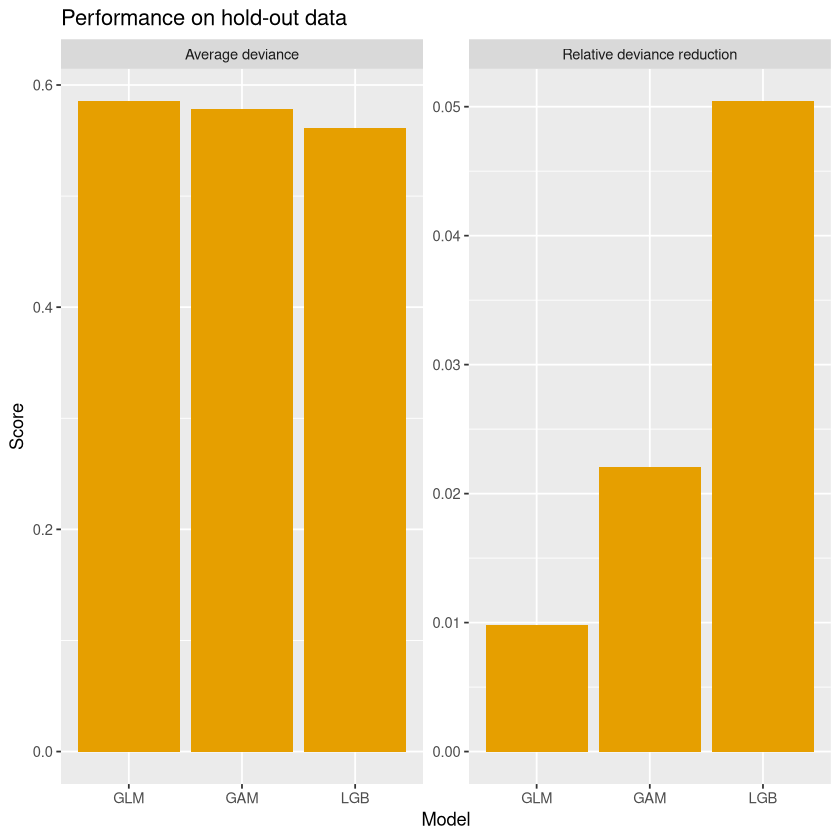

In [2]:
training_mean <- weighted.mean(train[[y]], train[[w]])
perf <- light_performance(fls, reference_mean = training_mean)
perf$data

plot(perf, fill = fillc) +
  labs(title = "Performance on hold-out data", x = "Model", y = "Score")


**Comments:** 

- The more flexible our models, the higher their performance.
- The performance differences between the models are remarkable. There appears to be strong nonlinearity (GLM versus GAM) and strong interaction effects (GAM versus boosting).
- At first glance, a single-digit % deviance reduction seems modest. However, since a motor TPL claim is a rare and unpredictable event, this is quite normal.

Next, let us compare the hold-out performance scores with their in-sample counterparts:

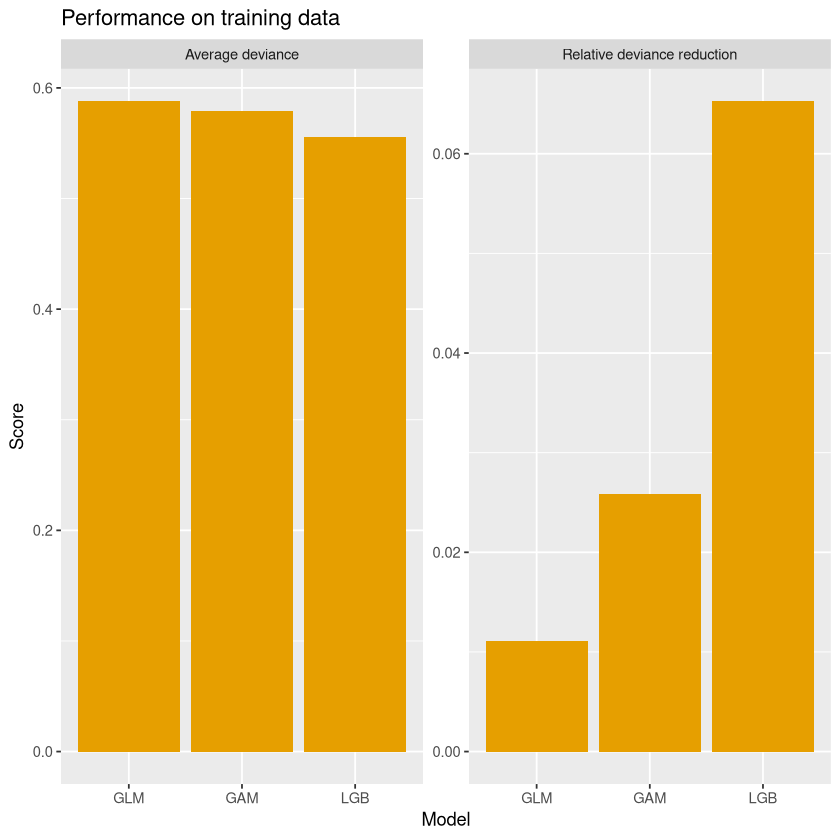

In [3]:
light_performance(fls, data = train) |>
  plot(fill = fillc) +
  labs(title = "Performance on training data", x = "Model", y = "Score")


**Comment:** The values calculated on the basis of the training data are higher for all models, which is in line with our expectations. The relative optimism increases with higher model flexibility.

## General remarks

- It often makes sense to study different types of performance measures. In our example, we considered an absolute and a relative measure.
- A flawed validation strategy (see the excursion below for an example) tends to result in biased performance values. Such errors are often overlooked because their detection requires detailed knowledge of the data structure and the modeling process.

# Excursion: Grouped Data

In our example on French claims frequencies, we have split the dataset into train/test by *grouped splitting* on the column "group_id". The same logic was also applied in cross-validation to search for good parameter combinations of the boosted trees model. 

Grouped splitting works as follows: Unlike standard random splitting, where each row is randomly assigned to a data partition, all rows in a group are randomly assigned to the same partition. Thus, a group appears in exactly one partition. This ensures that no within-group information is leaked across partitions. Failure to do so may lead to biased performance evaluations and consequently to biased model selection. Typically, very flexible modeling techniques benefit from such bias, which unfortunately means that overfitting is rewarded.

Grouped data occur quite frequently. Here some examples:

- In insurance pricing datasets, each policy typically appears multiple times, e.g., once per year.
- In loss reserving, claims occurring during an accumulation event (e.g., a hail storm or a flood) are not independent.
- Tracking browser behavior of online visitors produces many lines of rows of the same visitor.
- An application from banking: financial transactions from clients.

Ignoring data structure during data partitioning is a common flaw in data science. Avoiding it is important.

## Example: Mind your data structure

How would the model performances of our GLM and the boosted trees model change if grouping were ignored?

First, we show the data rows belonging to the largest "group_id".

In [4]:
# The largest group_id
prep |>
  filter(group_size == max(prep$group_size)) |>
  select_at(c("IDpol", "group_id", y, w, x))

# Random split
n <- nrow(prep)
with_seed(
  1,
  ix <- sample(1:n, 0.8 * n)
)
train_u <- prep[ix, ]
test_u <- prep[-ix, ]

# GLM
if (refit) {
  fit_glm_u <- glm(
    reformulate(x, y),
    data = train_u,
    family = quasipoisson(),
    weights = train_u[[w]]
  )
  saveRDS(fit_glm_u, file = file.path(main, "fit_glm_u.rds"))
} else {
  fit_glm_u <- readRDS(file.path(main, "fit_glm_u.rds"))
}

# Boosted trees
if (refit) {
  dtrain_u <- lgb.Dataset(
    data.matrix(train_u[x]),
    label = train_u[[y]],
    weight = train_u[[w]],
    params = list(feature_pre_filter = FALSE)
  )

  # Parameter set was determined by CV on *randomly split* folds,
  # see "french_motor/tune_nongrouped_lgb.R"
  params_u <- list(
    learning_rate = 0.05,
    objective = "poisson",
    metric = "poisson",
    num_leaves = 63,
    min_data_in_leaf = 50,
    min_sum_hessian_in_leaf = 0.1,
    colsample_bynode = 1,
    bagging_fraction = 0.8,
    lambda_l1 = 4,
    lambda_l2 = 0,
    num_threads = 7 # depending on your system
  )

  # Fit LGB model on best parameter combination
  with_seed(
    837,
    fit_lgb_u <- lgb.train(params = params_u, data = dtrain_u, nrounds = 362)
  )
  lgb.save(fit_lgb_u, file.path(main, "fit_lgb_u.txt"))
} else {
  fit_lgb_u <- lgb.load(file.path(main, "fit_lgb_u.txt"))
}

# Relative deviance gains
training_mean_u <- weighted.mean(train_u[[y]], train_u[[w]])

r_squared_poisson(
  test_u[[y]],
  predict(fit_glm_u, test_u, type = "response"),
  w = test_u[[w]],
  reference_mean = training_mean_u
)

r_squared_poisson(
  test_u[[y]],
  predict(fit_lgb_u, data.matrix(test_u[x])),
  w = test_u[[w]],
  reference_mean = training_mean_u
)


IDpol,group_id,Freq,Exposure,VehPower,VehAge,VehBrand,VehGas,DrivAge,logDensity,PolicyRegion
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
2285383,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285384,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285386,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285387,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285388,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285389,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285390,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285391,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other
2285392,139307,0,0.66,9,3,B2,Regular,35,4.521789,Other


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 7
[LightGBM] [Info] Start training from score -2.323655


[1] 0.01080669

[1] 0.05165248

**Comments:** 

- The largest "group_id" has 22 rows. Not only are all their risk factors identical (this fact was used to construct the "group_id"), but also their "IDpol" values are very similar. Furthermore, their exposures and claim frequencies are identical. Models that are good at memorizing the training data will benefit if the rows of this observation appear also in the test data. But is it really a problem in our case?
- The test R-squared of the GLM is now 1.08%, while it was 0.98% in the grouped setting. For the LightGBM model, the test R-squared is also higher (5.17% vs. 5.04%) but to a lesser extent than for the GLM.
- In this example, the bias from ignoring grouping structure is not large.

## Example: Simulation

To further dig into the topic of grouped data, let us create an artificial regression situation with ten features. Feature values and the response are randomly generated with no correlation between columns. We then use a 80%/20% split to examine how well a linear regression and a random forest perform in-sample and out-of-sample with increasing proportions of duplicated rows. In an ideal validation scheme, the out-of-sample R-squared should be close to 0. What do we get with random splitting? What if we perform grouped splitting on groups of identical rows?

,group,y,V1,V2,V3
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-0.8043316,-0.6264538,1.13496509,-0.88614959
2,2,-1.0565257,0.1836433,1.11193185,-1.92225490
3,3,-1.0353958,-0.8356286,-0.87077763,1.61970074
4,4,-1.1855604,1.5952808,0.21073159,0.51926990
5,5,-0.5004395,0.3295078,0.06939565,-0.05584993


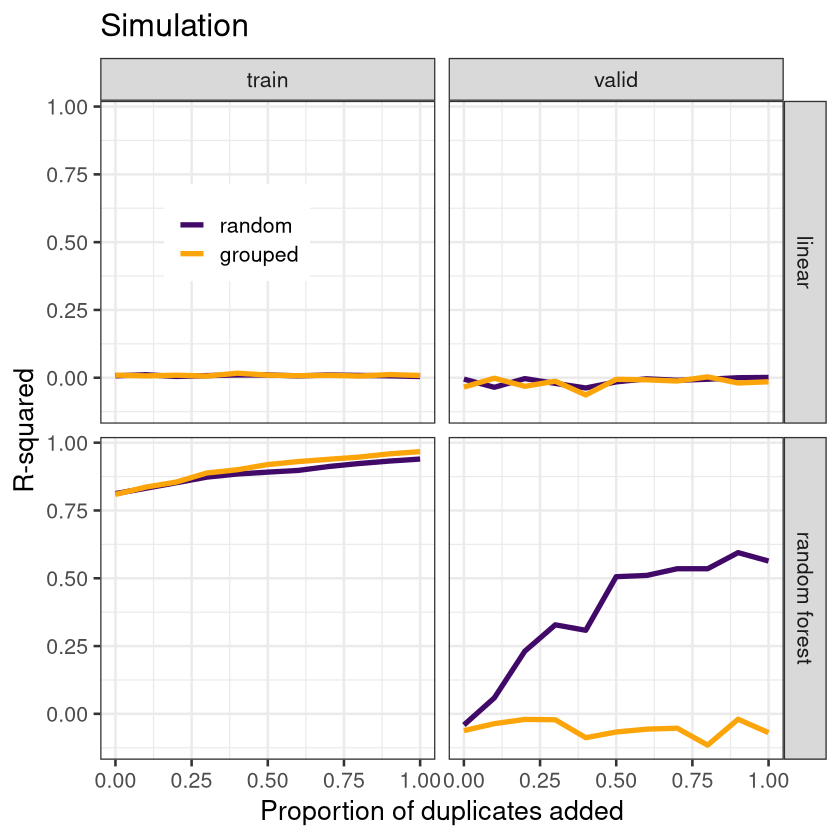

In [5]:
library(tidyverse)
library(ranger)

# 1) Generate regression dataset without any true associations
n <- 1000
p <- 10

set.seed(1)

df <- rnorm(n * p) |>
  matrix(ncol = p) |>
  as.data.frame() |>
  mutate(y = rnorm(n), group = 1:n) |>
  select(group, y, everything())
df[1:5, 1:5]

# 2) Initialize results array
dims <- list(
  prop = seq(0, 1, by = 0.1),
  splittype = c("random", "grouped"),
  model = c("linear", "random forest"),
  datapart = c("train", "valid")
)
res <- array(dim = lapply(dims, length), dimnames = dims)

# 3) Define helper functions

# - Same prediction function for lm() and ranger()
pred <- function(fit, df) {
  if (inherits(fit, "lm")) {
    return(predict(fit, df))
  }
  predict(fit, df)$predictions
}

# - R-squared
r2 <- function(y, pred, train_y = y) {
  mse <- function(x, z) mean((x - z)^2)
  1 - mse(y, pred) / mse(y, mean(train_y))
}

# - Train and (clean) validation R-squared
both_r2 <- function(fit, train, valid) {
  c(
    r2(train$y, pred(fit, train)),
    r2(valid$y, pred(fit, valid), train_y = train$y)
  )
}

# 4) Simulation
for (prop in dims$prop) {
  # Add some duplicates to the original data
  df_ <- rbind(df, df[sample(1:n, n * prop), ])
  n_ <- nrow(df_)
  for (splittype in dims$splittype) {
    if (splittype == "random") {
      ix <- (1:n_) %in% sample(1:n_, n_ * 0.8)
    } else {
      ix <- df_$group %in% sample(1:n, n * 0.8)
    }
    df_train <- df_[ix, ]
    df_valid <- df_[!ix, ]

    for (model in dims$model) {
      model_function <- switch(model,
        linear = lm,
        ranger
      )
      fit <- model_function(y ~ . - group, data = df_train)
      res[as.character(prop), splittype, model, ] <- both_r2(fit, df_train, df_valid)
    }
  }
}

# 5) Visualization
as.data.frame.table(res) |>
  ggplot(aes(x = as.numeric(as.character(prop)), y = Freq, color = splittype)) +
  geom_line(linewidth = 1.5) +
  facet_grid(model ~ datapart) +
  theme_bw(base_size = 16) +
  theme(legend.position = c(0.2, 0.8), legend.title = element_blank()) +
  scale_color_viridis_d(begin = 0.2, end = 0.8, option = "inferno") +
  labs(y = "R-squared", x = "Proportion of duplicates added", title = "Simulation")


**Comments:** 

- Most importantly: Grouped splitting provides good estimates of the actual performance on the validation data, both for the linear regression and the random forest, regardless of how many duplicates are added. However, this requires *knowing* and *respecting* the grouping structure.
- Linear regression provides quite homogeneous results in all situations/aspects (why?).
- In-sample, the random forest shows strong overfitting in all scenarios. This is not surprising: a random forest consists of deep trees, which leads to an exaggerated in-sample performance. In fact, it is never useful to study the in-sample performance of a random forest except for didactic reasons... In practice, one prefers to look at the out-of-bag (OOB) performance instead. (How is it calculated? What is the impact of grouped data on OOB results?)
- Out-of-sample and with random splitting, the random forest shows biased results, even for low proportions of duplicates. This is a dangerous scenario: an inappropriate validation scheme combined with a flexible modeling technique. Such problems are difficult to detect and are usually a consequence of 
  - not knowing the dataset well enough,
  - having pressure to develop a seemingly good model, or
  - overconfidence of the modeler.

## More on dependent data

In our main modeling example, we use the grouping structure only to create clean data splits. However, in other situations, one may want to explicitly use within-group information in the model: An example is an insurance product that is associated with a high claim frequency, such as insurance for large fleets of vehicles. Here, one could apply a policy-specific residual correction according to credibility theory. As with time series data, such *panel-data* require special attention not only in the choice of the validation scheme, but also in feature construction, selection of modeling technique, and calculation of predictions. 

Although we cannot cover these aspects here, we cannot emphasize enough the importance of paying attention to data structure.

# Variable Importance

After having studied model performance, we now go a step further and consider variable importance. It is often a very valuable information to see which features have the strongest impact on the predictions, and - on the other hand - which features are hardly of any importance. 
Besides the pure information gain, variable importance also helps to challenge the correctness of the model. Are the results as expected or not? If a seemingly unimportant variable is one of the top predictors, then maybe some sort of information leakage from the response to that feature has happened (see also the discussion in section "Performance"). On the other hand, if a key variable does not show any relevance in the model, this could mean that some mistake happened in data preparation or that the modeler does not yet sufficiently understand the modeling situation or the data.

There are different model-specific ways to assess variable importance, here some examples:

- Linear models
  - Normalized coefficients or 
  - partial F/Chi-squared tests per feature.
- Tree-based models
  - Split gain, i.e., the overall loss gain from splitting on feature $X^{(j)}$ or
  - the number of times the feature was used for splitting.

The most frequently applied *model-agnostic* technique is called *permutation importance* introduced in the famous random forest paper [@breiman2001] for random forests and later generalized by @fisher2018 to other models. It measures by how much a relevant performance measure $\hat S$ (e.g., the average deviance or the RMSE) of a fitted model $\hat m$, evaluated on a dataset $D$, worsens after randomly shuffling the values of the $j$-th feature. The larger the performance change, the more important the feature.

Formally, permutation importance $\text{PVI}(j, D)$ of the $j$-th feature $X^{(j)}$ and data $D$ can be defined as follows:
$$
  \text{PVI}(j, D) = \hat S(\hat m, D^{(j)}) - \hat S(\hat m, D),
$$
where $D^{(j)}$ is a version of $D$ with randomly permuted values in the column representing the $j$-th feature $X^{(j)}$. For simplicity, we assume that the performance measure $\hat S$ is defined such that smaller values mean better performance. 

In pseudocode, copied from @mayer2020, the algorithm to calculate the permutation importance for all features is as follows:

![Algorithm: Permutation importance](figs/algo1_imp.png){#id .class width=60%}

If there are $p$ features and $n$ is the sample size of $D$, then $n(p+1)$ predictions have to be calculated. Compared to other methods from XAI, this is a relatively cheap operation. Note that the process can be repeated multiple times to increase (and assess) robustness of the results.

## Remarks

- During the process of calculating permutation importance, the model is never refitted.
- There is no mathematical definition of variable importance. Different types of variable importance measures thus often lead to inconsistent results.
- Generally, variable importance measures struggle with strongly collinear (or even strongly causally dependent) features. The problem can usually be reduced by applying clever data transformations during feature construction, i.e., before modeling. Example: the age $v$ of the driver and the "age" $t$ of the driving license can often be decorrelated by considering $v$ and $v-t$ instead of the original features $v$ and $t$. The use of such transformations contrasts with the bad habit of blindly throwing all available columns into the model.
- Calculating permutation importance requires the response variable. In order to not influence the results by overfitting, it usually makes sense to evaluate it on a hold-out data set. Can you think of a situation where one would rather consider the in-sample version?
- Different versions of permutation importance exist. For example, instead of studying absolute drops in performance, one could also use relative drops.

## Example

Let us now calculate permutation importance for our three models on the hold-out dataset and with respect to the exposure-weighted average Poisson deviance:

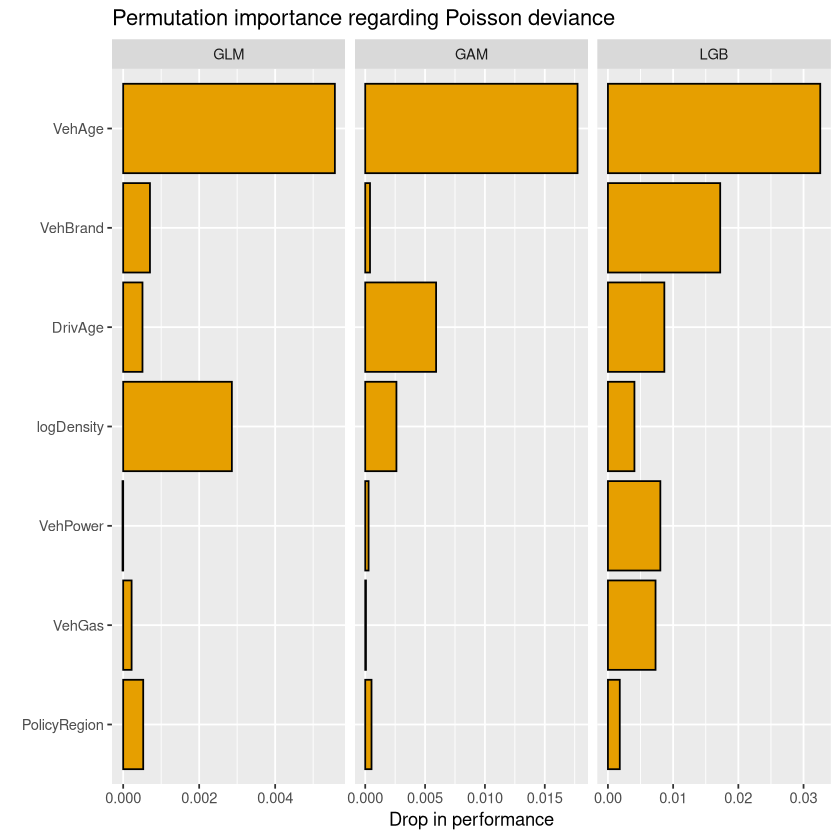

In [6]:
# By default, flashlight uses the first metric to calculate permutation importance
# Takes quite long, so we store the results
if (reload) {
  imp <- readRDS(file.path(main, "imp.rds"))
} else {
  imp <- light_importance(fls, v = x)
  saveRDS(imp, file = file.path(main, "imp.rds"))
}
plot(imp, fill = fillc, color = "black", facet_scales = "free_x") +
  ggtitle("Permutation importance regarding Poisson deviance")


**Comments:** The results make intuitively sense, even if they differ across models.

To compare the results of permutation importance with those from a model-specific variable importance measure, we also calculate split gain importance values of our boosted trees model. Note that split gain importance is calculated on the training data.

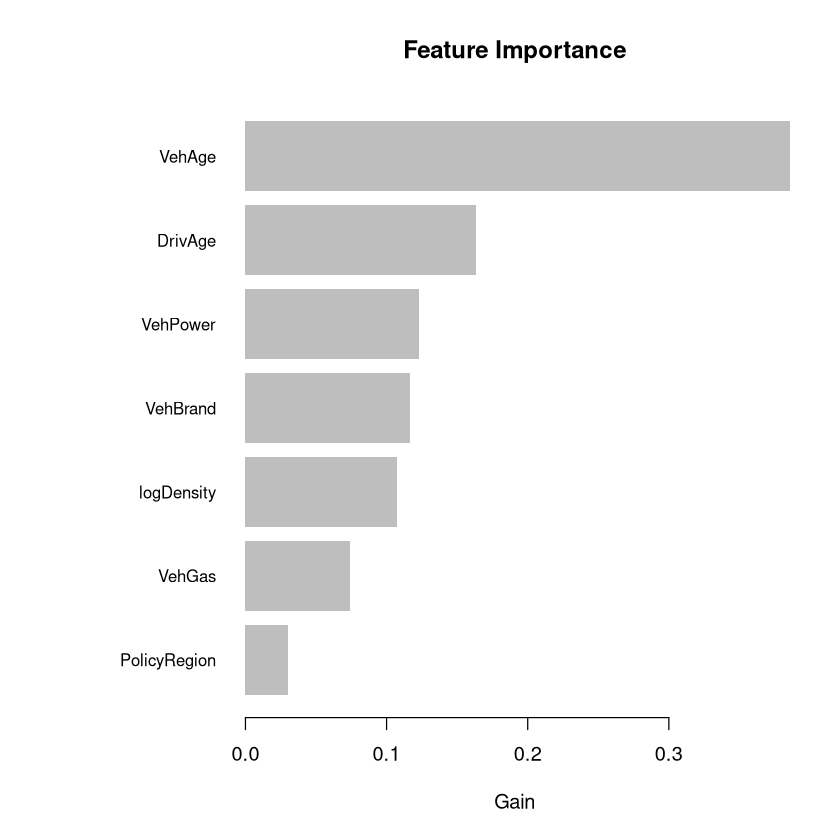

In [7]:
# Split gain importance regarding Poisson deviance
fit_lgb |>
  lgb.importance() |>
  lgb.plot.importance()


**Comments:** The results are quite different from permutation importance. Nevertheless, the two methods identify the same feature as the most important one.

# Effects

One of the advantages of an additive GLM over a complex ML model is its simple structure: the model equation directly tells how the predictions (at the scale of the link function) will react to changes in a covariate $X^{(j)}$ of interest, holding all other covariates fixed ("Ceteris Paribus"). Due to additivity, the effect of $X^{(j)}$ is the same for all observations.

In this section, we will explore methods that describe the effects of covariates for general ML models. Due to possibly complex interaction effects, such descriptions are usually only approximations.

## Individual conditional expectations

In a linear regression 
$$
  \mathbb E (Y \mid \boldsymbol{x}) \approx m(\boldsymbol{x}) = \beta_o +\beta_1 x^{(1)} + \dots + \beta_p x^{(p)},
$$
the effect of a covariate $X^{(j)}$ is described by its estimated coefficient $\hat \beta_j$. Similarly, in an additive model
$$
  \mathbb E (Y \mid \boldsymbol{x}) \approx m(\boldsymbol{x}) = \beta_o +f_1(x^{(1)}) + \dots + f_p(x^{(p)}),
$$
the estimated effect $\hat{f_j}$ of $X^{(j)}$ can be visualized by plotting the component $\hat{f_j}(v)$ against $v$. This curve will be parallel to the corresponding *individual conditional expectation (ICE)* curve [@goldstein2015] of any observation.

The ICE function for covariate $X^{(j)}$ of model $m$ and an observation with covariate vector $\boldsymbol x \in {\mathbb R}^p$ is given by 
$$
  \text{ICE}_j: v \in {\mathbb R} \mapsto m(v, \boldsymbol x_{\setminus j}),
$$
where $\boldsymbol x_{\setminus j}$ denotes all but the $j$-th component of $\boldsymbol x$, which is being replaced by the value $v$.

The corresponding ICE curve represents the graph $(v, \text{ICE}_j(v))$ for a grid of values $v \in \mathbb R$. In pseudocode, copied from @mayer2020, the algorithm to calculate $ICE_j(v)$ works as follows:

![Algorithm: ICE](figs/algo2_ice.png){#id .class width=60%}

An ICE *plot* finally shows the ICE curves of multiple observations.

### Remarks 

- If the model $m$ involves a link function, ICE curves are often plotted on the link scale (why?).
- The more different the curves in an ICE plot for covariate $X^{(j)}$ (ignoring vertical shifts), the stronger are the interaction effects with other covariates. If there are no interaction effects between $X^{(j)}$ and the other covariates, the curves are parallel.
- ICE curves can be vertically centered to focus on interaction strength. These curves are called "c-ICE" curves. For a model additive in $X^{(j)}$, the c-ICE plot of $X^{(j)}$ shows a single curve (why?).
- Above, we defined the ICE function of a single feature $X^{(j)}$. Similarly, two- (or higher-dimensional) ICE functions can be defined.
- Since calculating ICE curves does not take into account the response variable, it should not matter whether the observations are selected from the training or the test data.

### Pros and Cons

- Pro: Very simple to compute.
- Pro: Easy to interpret thanks to Ceteris Paribus logic.
- Pro: Gives an impression about associated interaction strength.
- Con: Suboptimal when Ceteris Paribus clause is unnatural.
- Con: Model is applied to rare/impossible feature value combinations.
- Con: One does not see which variable is interacting.

### Example

How do ICE and c-ICE curves for the driver age of 200 randomly selected observations look on both the frequency and log-frequency scale?

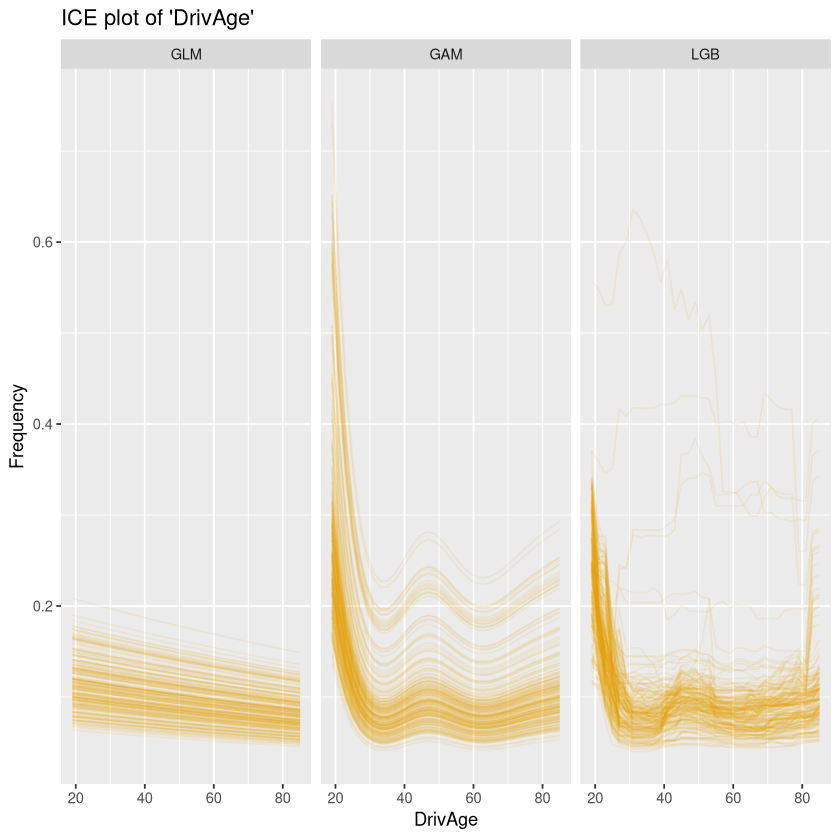

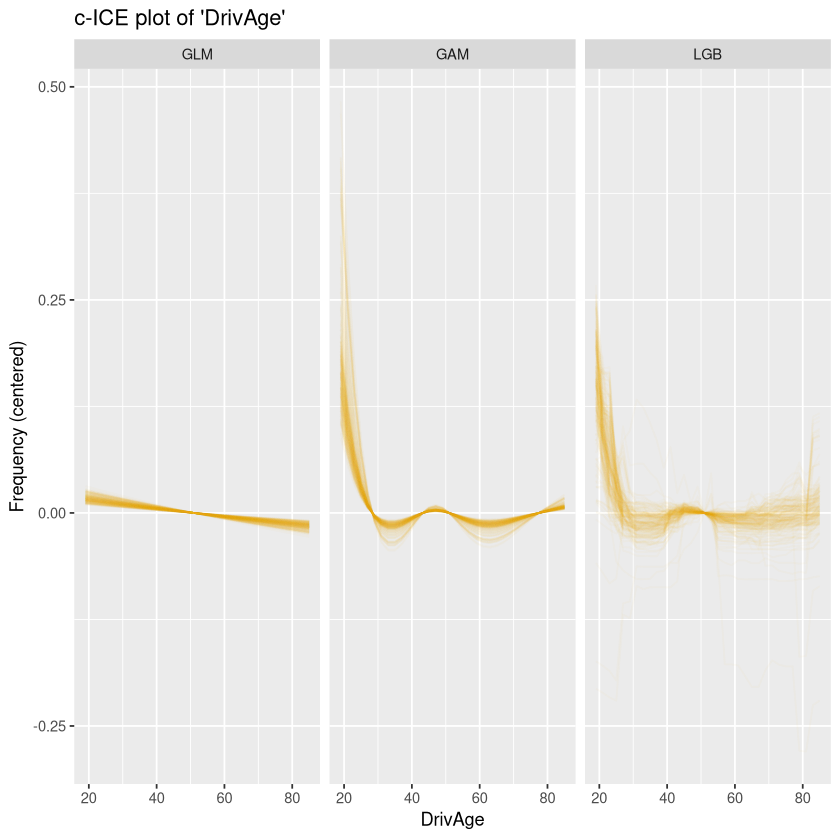

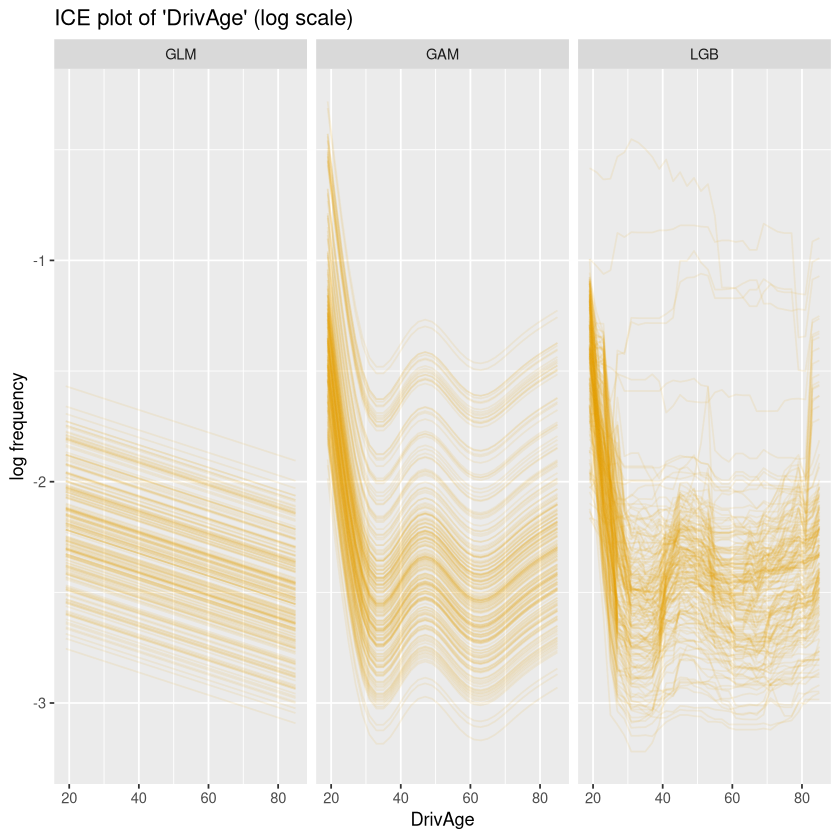

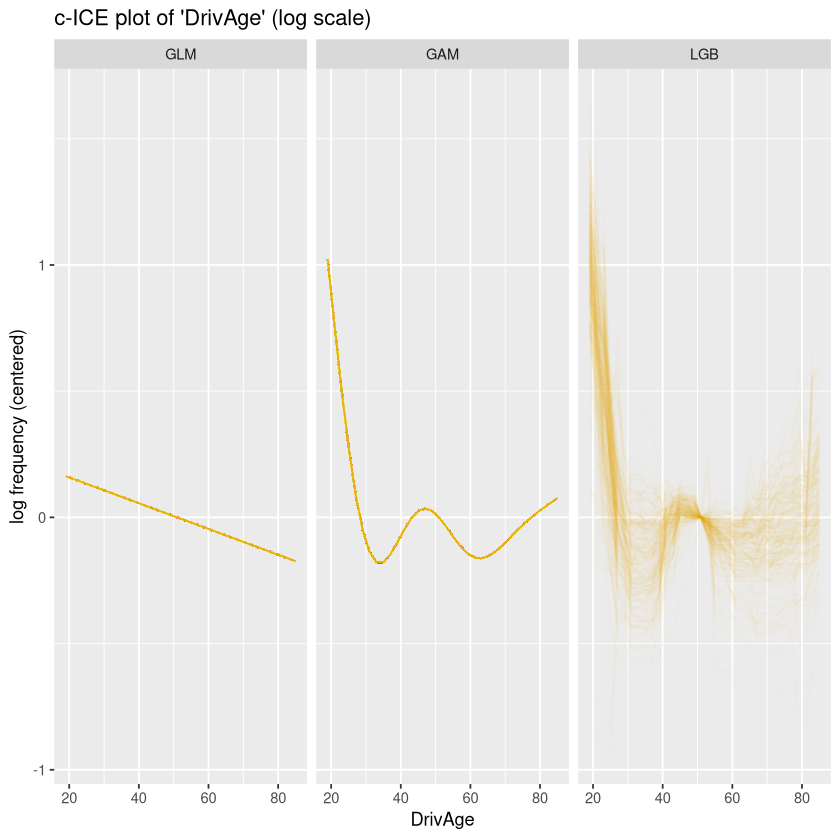

In [8]:
# Same observations for all (sub-)plots
with_seed(
  3,
  indices <- sample(1:nrow(test), 200)
)

light_ice(fls, v = "DrivAge", indices = indices) |>
  plot(alpha = 0.1, color = fillc) +
  labs(y = "Frequency", title = "ICE plot of 'DrivAge'")

light_ice(fls, v = "DrivAge", indices = indices, center = "middle") |>
  plot(alpha = 0.03, color = fillc) +
  labs(y = "Frequency (centered)", title = "c-ICE plot of 'DrivAge'")

light_ice(fls_log, v = "DrivAge", indices = indices) |>
  plot(alpha = 0.1, color = fillc) +
  labs(y = "log frequency", title = "ICE plot of 'DrivAge' (log scale)")

light_ice(fls_log, v = "DrivAge", indices = indices, center = "middle") |>
  plot(alpha = 0.03, color = fillc) +
  labs(y = "log frequency (centered)", title = "c-ICE plot of 'DrivAge' (log scale)")


**Comments:**

- On the link scale, the ICE curves of the GLM and the GAM are parallel, reflecting the fact that these models do not include interaction effects between the driver age and other factors.
- The boosted trees model shows varying ICE curves. The effect of the age of the driver clearly depends on the values of the other covariates. We can describe the effect for selected observations, but not simultaneously for all possible feature combinations.
- c-ICE curves help to focus on studying interactions.

## Partial dependence

The pointwise average of many ICE curves is called a *partial dependence plot* (PDP), originally introduced by @friedman2001 in his seminal work on gradient boosting. It describes the effect of the variable $X^{(j)}$, averaged over all interaction effects and holding all other variables fixed. The empirical partial dependence function for model $\hat m$ and feature $X^{(j)}$ is given by
$$
  \text{PD}_j(v) = \frac{1}{n} \sum_{i = 1}^n \hat m(v, \boldsymbol x_{i,\setminus j}),
$$
where $\boldsymbol x_{i,\setminus j}$ denotes the feature vector without $j$-th component of observation $i$ in some reference dataset, often the training or the test data. In modeling situations involving case weights, the arithmetic average is replaced by a corresponding weighted average. $\text{PD}_j(v)$ serves as estimate of $\mathbb E_{\boldsymbol X_{\setminus j}}m(v, \boldsymbol X_{\setminus j})$ . The expectation runs over the joint marginal distribution of $\boldsymbol X_{\setminus j}$, i.e., of all features except the $j$-th component.

The corresponding PDP represents the graph $(v, \text{PD}_j(v))$ for a grid of values $v \in \mathbb R$.

The algorithm (in pseudocode) for evaluating the partial dependence function for a grid of values for $v$ is copied from @mayer2020:

![Algorithm: PDP](figs/algo3_pd.png){#id .class width=60%}

Sometimes two-dimensional partial dependence plots of the features $X^{(j)}$ and $X^{(k)}$ are to be studied. Then, the corresponding empirical partial dependence function is given by
$$
  \text{PD}_{jk}(v_j, v_k) = \frac{1}{n} \sum_{i = 1}^n \hat m(v_j, v_k, \boldsymbol x_{i,\setminus \{j, k\}}),
$$
where $\boldsymbol x_{i,\setminus \{j, k\}}$ is the feature vector of observation $i$ without the $j$-th and $k$-th components. We will need this construction later in the section on interaction strength.

### Example

Let us now study the (exposure-weighted) partial dependence plots for all features in our claims frequency models on the link scale. We do this in decreasing order of their (average) permutation importance.

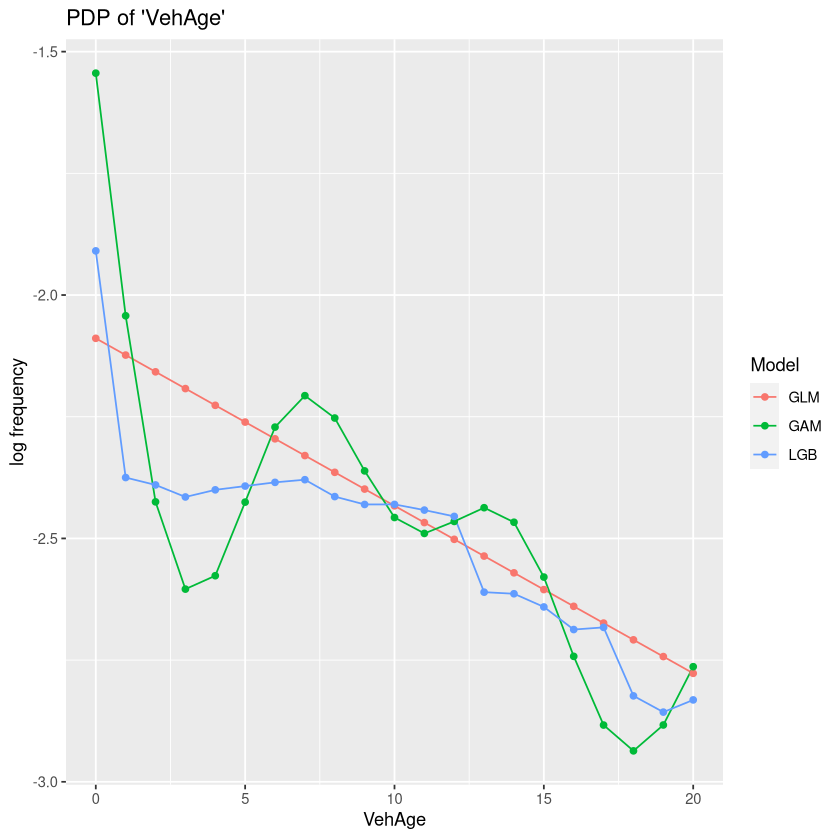

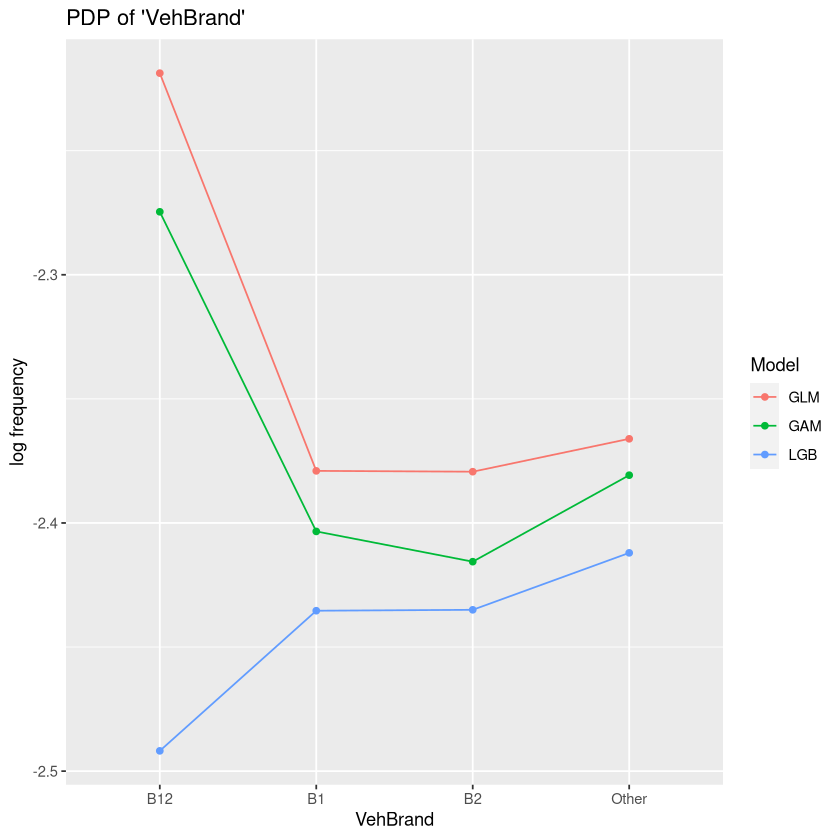

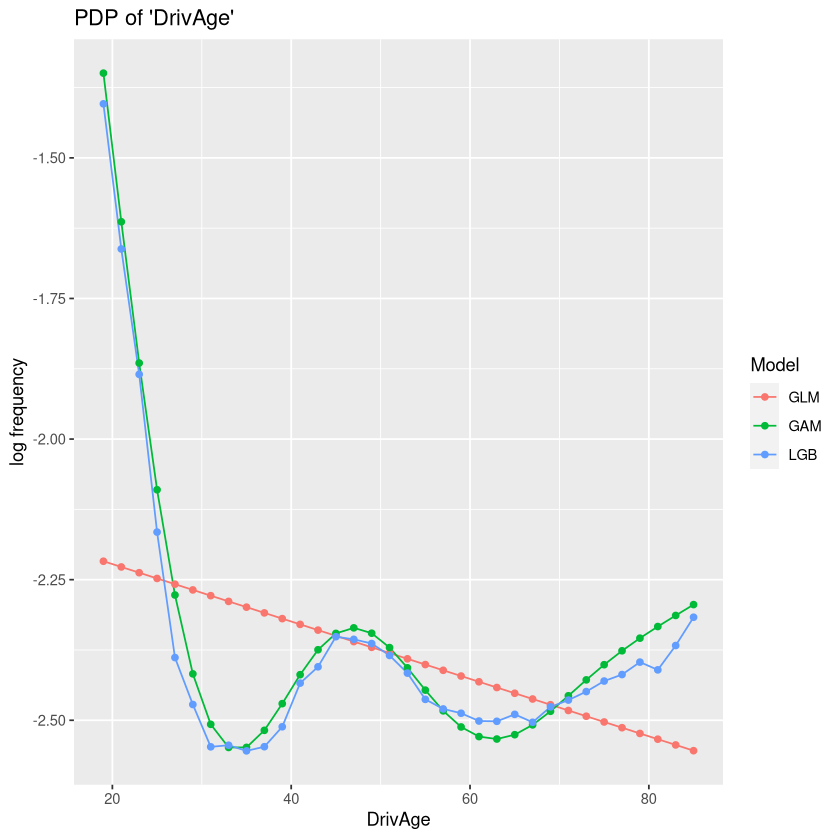

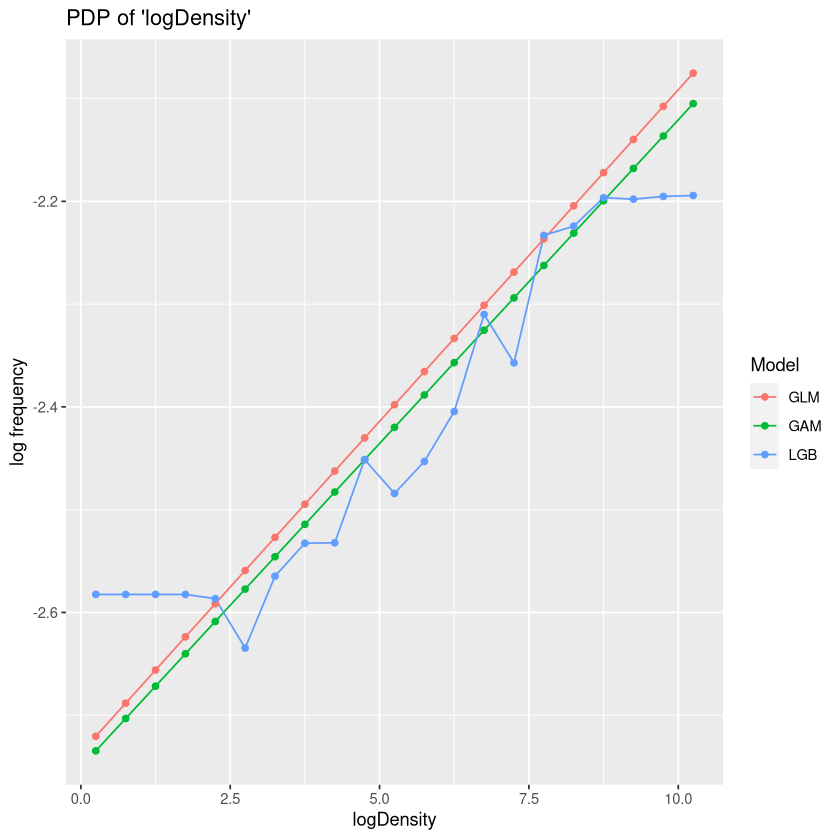

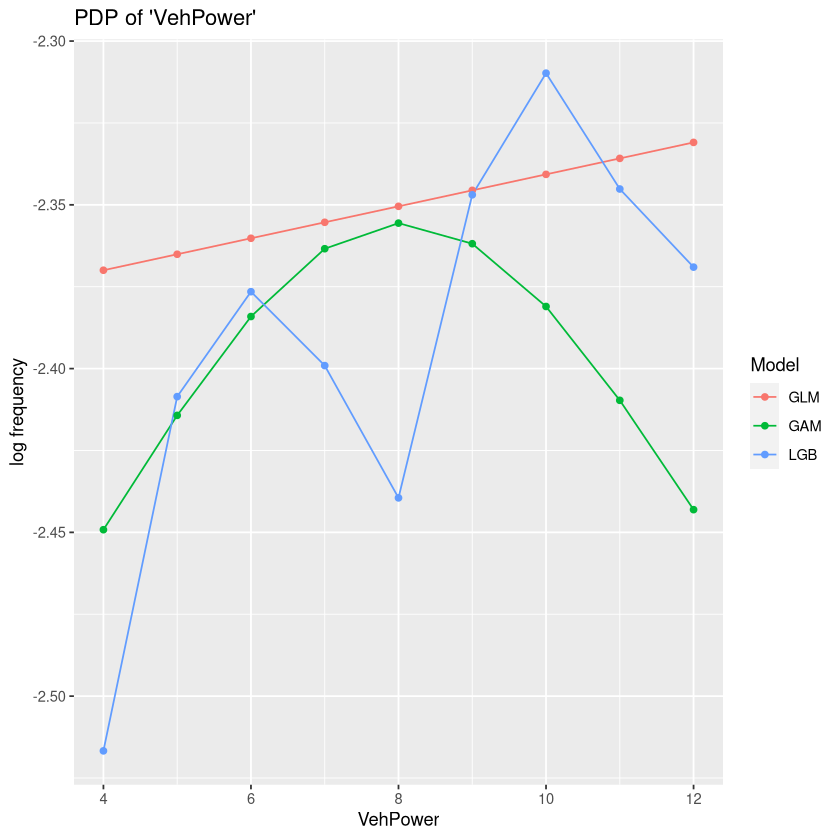

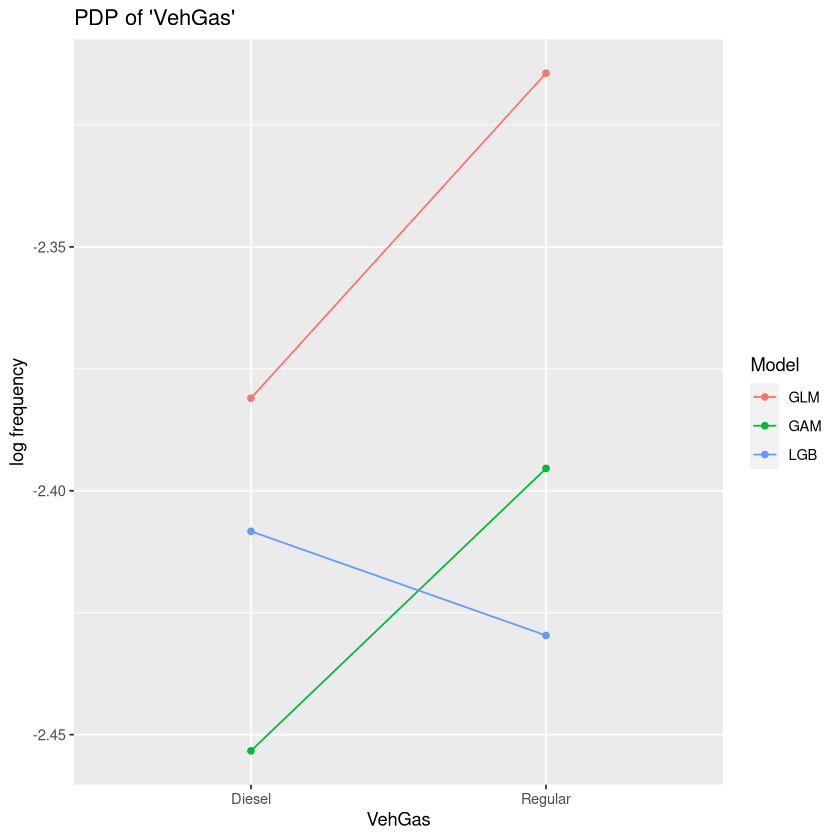

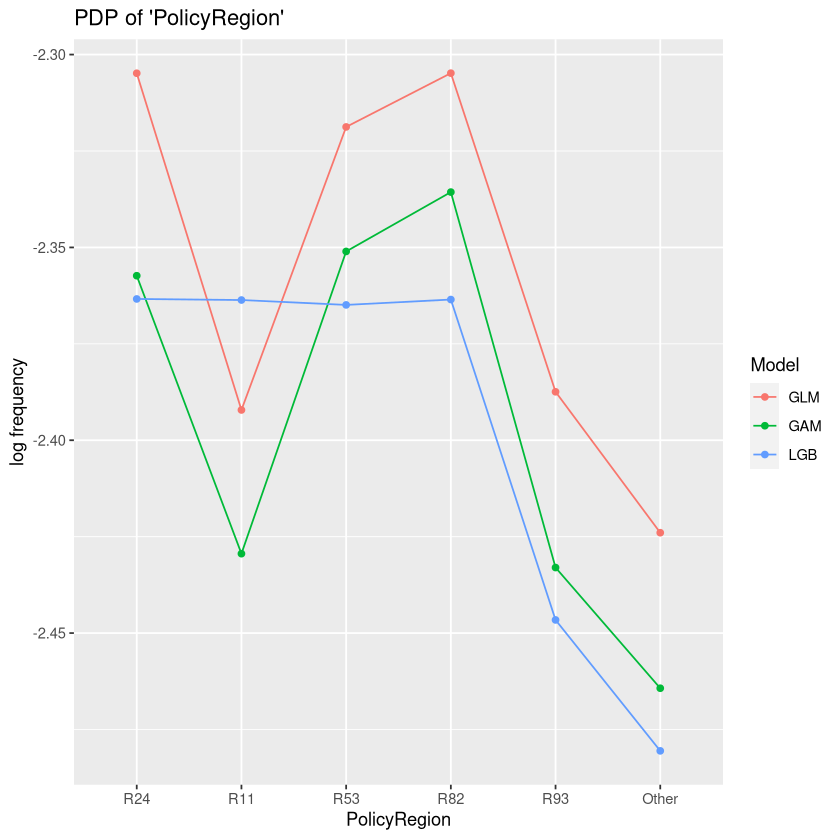

In [9]:
# Each partial dependence plot corresponds to the average of 1000 ICE curves
for (v in most_important(imp)) {
  pr <- light_profile(fls_log, v = v, n_bins = 25) |>
    plot() +
    labs(y = "log frequency", color = "Model", title = sprintf("PDP of '%s'", v))
  print(pr)
}


**Comments:**

- For some of the covariates, the effects are quite similar across models. For other covariates, the models show very different effects. This could be a consequence of strong omitted variable bias (why?).
- The effect of driver age in the GLM is clearly too simplistic. Typically, the claims frequency increases again for older individuals. The other two models seem to be more realistic here.
- The curves for the GLM visualize the estimates of the coefficients $\beta_j$, while the curves for the GAM visualize its additive components (why?).

### Pros and Cons

- Pro: Simple to compute.
- Pro: Easy to interpret thanks to Ceteris Paribus logic.
- Con: Suboptimal when Ceteris Paribus clause is unnatural.
- Con: Model is applied to rare/impossible feature value combinations.
- Con: No information about interactions.

An alternative to the partial dependence plot, the *accumulated local effects* (ALE) plot [@apley2016], attempts to overcome the first two (related) negative points. However, ALE plots are more difficult to calculate and to interpret. We will not consider them here.

## Classic diagnostic plots

In addition to ICE plots and PDPs, classic diagnostic regression plots (adapted for larger data) can be considered.

- *Response vs. covariate:* The average response (on original or link scale) is plotted against (binned) feature values of $X^{(j)}$. This visualization does not explain the *modeled* effect but rather the descriptive univariate effect present in the data. It gives an idea *how* to represent a feature in a model.
- *Predicted vs. covariate:* The average prediction (on original or link scale) is plotted against (binned) values of $X^{(j)}$. This plot shows the effect of $X^{(j)}$ combined with the effects of the other features and is therefore sometimes called marginal plot or M-plot [@apley2016]. Comparison with the corresponding partial dependence plot gives an impression about how much of the marginal effect of $X^{(j)}$ comes from $X^{(j)}$ alone.
- *Residual vs. covariate:* The average residual (on original or link scale) is plotted against (binned) values of $X^{(j)}$. If it is close to zero, then $X^{(j)}$ seems to be well represented in the model. If it is not, then the feature could be represented differently or with more parameters. This plot can be used for bias assessment and is closely related to calibration, see @fissler2022.

### Remarks

- Continuous predictors $X^{(j)}$ must be binned for all of these plots, at least for larger datasets. For small datasets, instead of plotting averages against binned $x$ values, one can simply examine scatter plots. In classic regression diagnostics, one usually works with the latter. The larger the data, the more reasonable it is to switch to the binning/average logic.
- In modeling situations with case weights, weighted averages are considered accordingly.
- Examining these plots for both the training data and the hold-out data provides additional insight. For example, if a residuals versus covariate plot shows greater bias for the hold-out data than for the training data, this could be an indication of overfitting.

### Example

Let us now consider these three types of plots for the covariate "DrivAge" evaluated on the hold-out data:

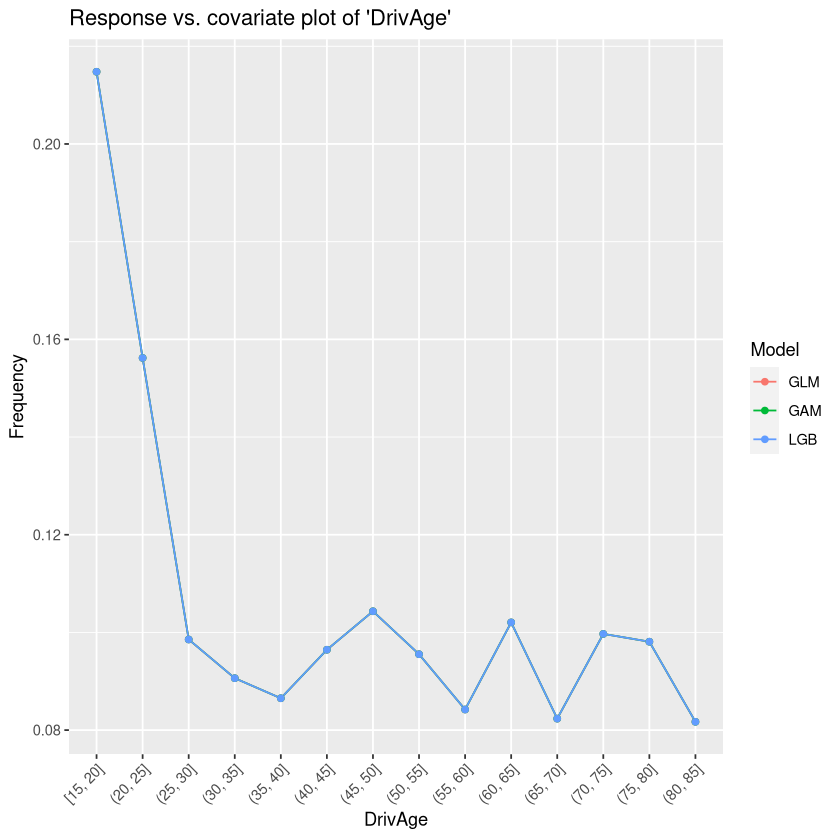

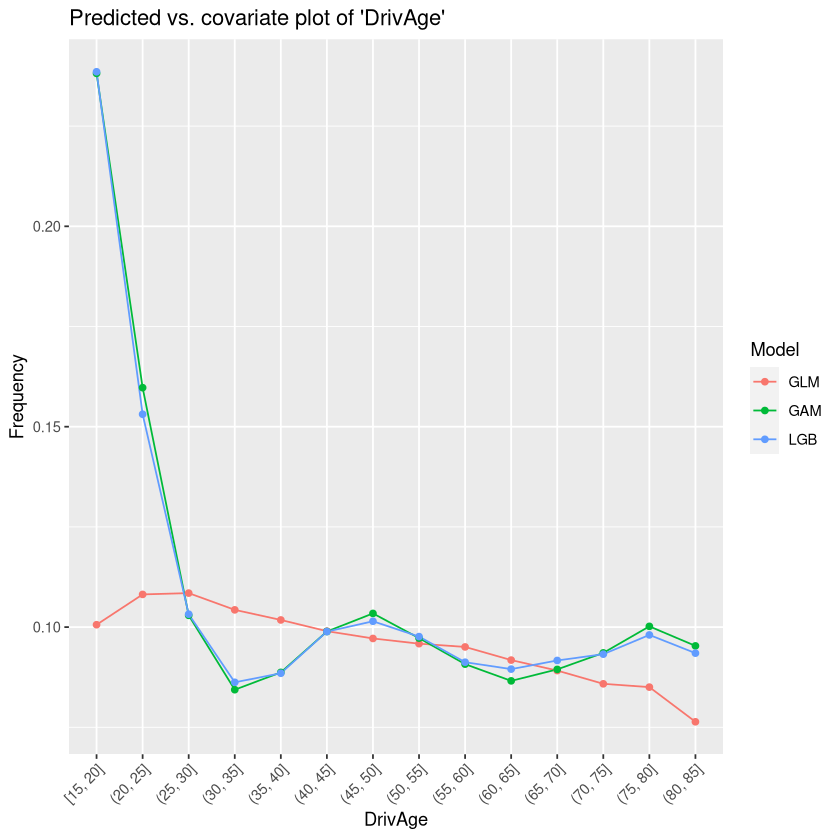

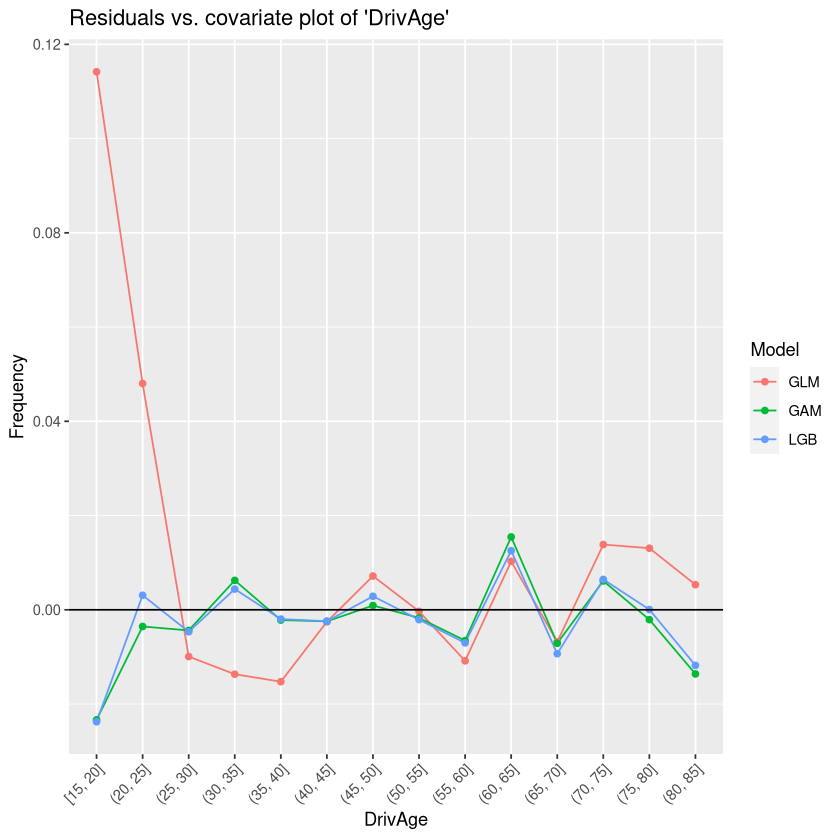

In [10]:
light_profile(fls, v = "DrivAge", type = "response") |>
  plot() +
  labs(
    title = paste("Response vs. covariate plot of 'DrivAge'"),
    color = "Model", y = "Frequency"
  )

light_profile(fls, v = "DrivAge", type = "predicted") |>
  plot() +
  labs(
    title = paste("Predicted vs. covariate plot of 'DrivAge'"),
    color = "Model", y = "Frequency"
  )

light_profile(fls, v = "DrivAge", type = "residual") |>
  plot() +
  geom_hline(yintercept = 0) +
  labs(
    title = paste("Residuals vs. covariate plot of 'DrivAge'"),
    color = "Model", y = "Frequency"
  )


**Comments**:

- *Response vs. covariate:* Claim frequencies for young drivers are much higher than for older people.
- *Predicted vs. covariate:* The GAM and the boosted trees model show almost identical average predictions. The GLM seems to grossly underestimate the expected frequency for young drivers.
- *Residual vs. covariate:* Consequently, the GLM exhibits a strong bias for young drivers. The other two models appear to be relatively unbiased across the age range.

### Pros and Cons

- Pro: Easy to calculate.
- Pro: Easy to interpret.
- Con: No Ceteris Paribus effects.
- Con: Continuous variables need to be binned, at least for larger datasets.

## Interaction effects

In linear models, one has to identify and add meaningful interaction effects by hand. This is in contrast to modern ML methods, which typically have sufficient flexibility to add complex interaction effects fully automatically. We have seen that ICE plots give a visual impression of the interaction strength associated with a single covariate $X^{(j)}$. Another interesting question is: between which variable *pairs* do strong interactions occur?

This can be done by looking at Friedman's $H$ statistic [@friedman2008] for pairwise interactions between covariates $X^{(j)}$ and $X^{(k)}$. It is defined as follows:
$$
	H^2_{jk}=\frac{\sum_{i=1}^n \Big[\text{PD}_{jk}(x_i^{(j)}, x_i^{(k)}) - \text{PD}_{j}(x_i^{(j)}) - \text{PD}_{k}(x_i^{(k)})\Big]^2}{\sum_{i=1}^n \Big[\text{PD}_{jk}(x_i^{(j)}, x_i^{(k)})\Big]^2},
$$
where the sums run over a reference dataset, e.g., a subset of the training or test data. Here, the partial dependence functions are all zero-mean centered. The part in the parentheses of the numerator measures the difference between the two-dimensional effect surface and the two univariate effects. Thus, $H^2$ can be interpreted as the proportion of variability in the joint effect of $X^{(j)}$ and $X^{(j)}$ unexplained by the main effects. The smaller the value, the weaker the pairwise interaction. A value close to 1 indicates that almost all of the effect of $X^{(j)}$ and $X^{(k)}$ comes from the pairwise interaction. According to this interpretation, it is often easier to work with $H^2$ than with $H$.

Since $H^2$ is a relative measure, it can be high even if the overall effects of the considered variables are weak. Thus, we propose to consider also the following measure of absolute interaction strength:
$$
	\tilde H_{jk} = \sqrt{\frac{1}{n}\sum_{i=1}^n\Big[\text{PD}_{jk}(x_i^{(j)}, x_i^{(k)}) - \text{PD}_{j}(x_i^{(j)}) - \text{PD}_{k}(x_i^{(k)})\Big]^2}.
$$

### Remarks

- There is also a version of Friedman's $H$ that summarizes total interaction strength associated with a single covariate $X^{(j)}$ as well as versions for interactions of order higher than two, see @friedman2008 or the Github project [hstats](https://github.com/mayer79/hstats).
- One way to visualize the interaction between two covariates, keeping everything else fixed, is to study two-dimensional partial dependence plots or, alternatively, stratified partial dependence or ICE plots.
- In the section on "SHAP" we will see another way to identify interactions.
- Algorithmically, calculating Friedman's $H$ for all variable pairs is computationally demanding. Thus, it often makes sense to consider only interactions between important variables.
- In order to ensure that additive models get $H$ and $\tilde H$ of 0, one typically works with predictions on the link scale.

### Pros and Cons

- Pro: Better than nothing.
- Con: Difficult to calculate.
- Con: Inherits problematic aspects of partial dependence.
- Con: Does not show *how* variables are interacting.

### Example

We now calculate both Friedman's $H^2$ and $\tilde H$ for all variable pairs built from the four most important covariates regarding permutation importance (see example above). Furthermore, we visualize a strong interaction both by a stratified and a two-dimensional partial dependence plot.

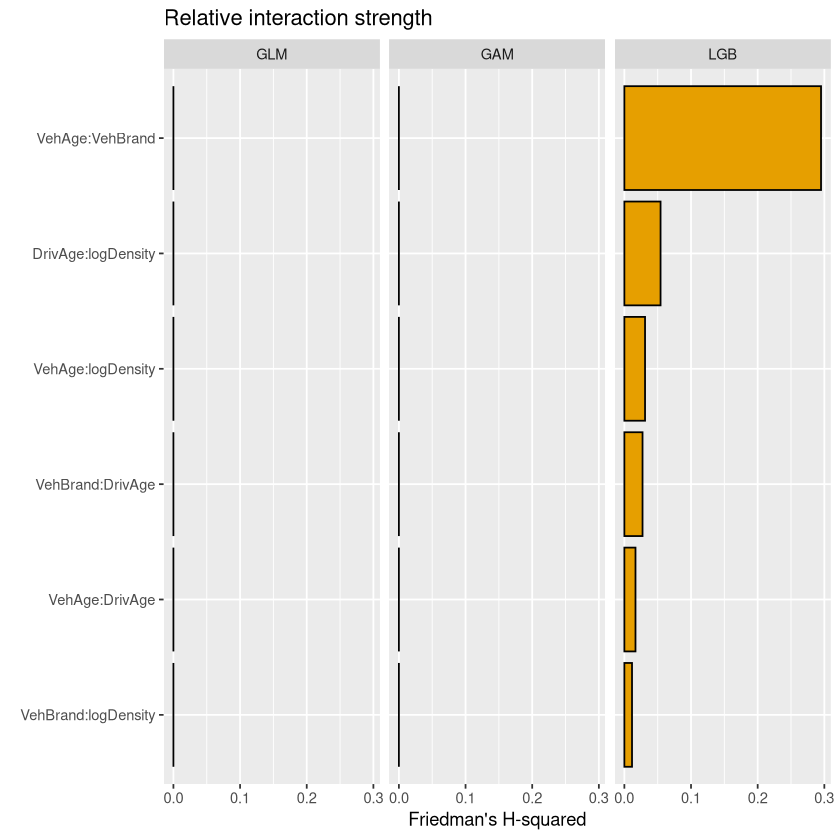

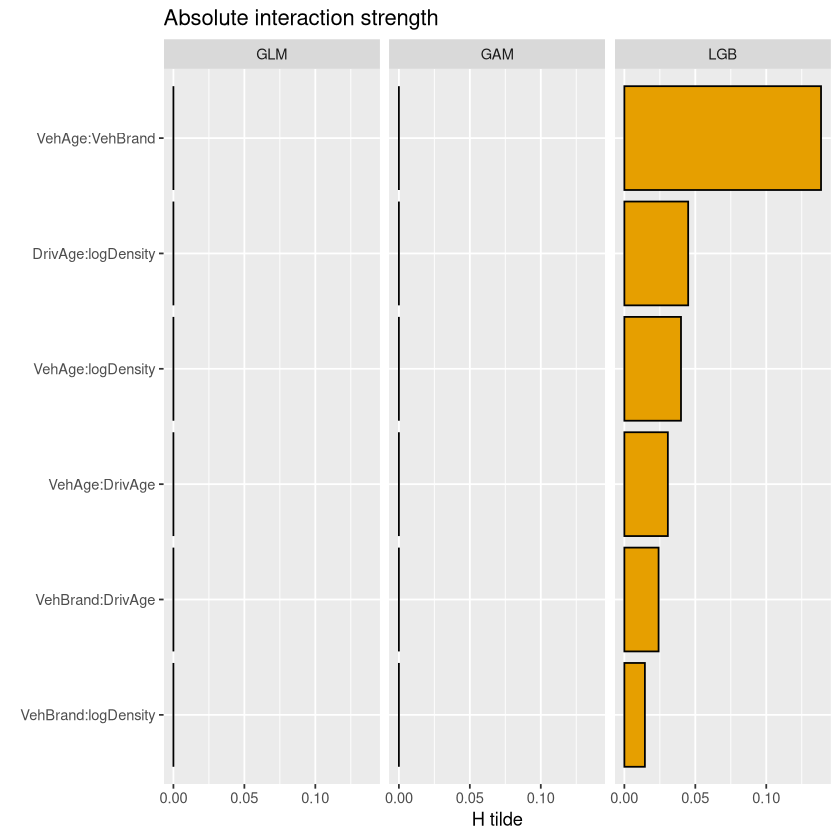

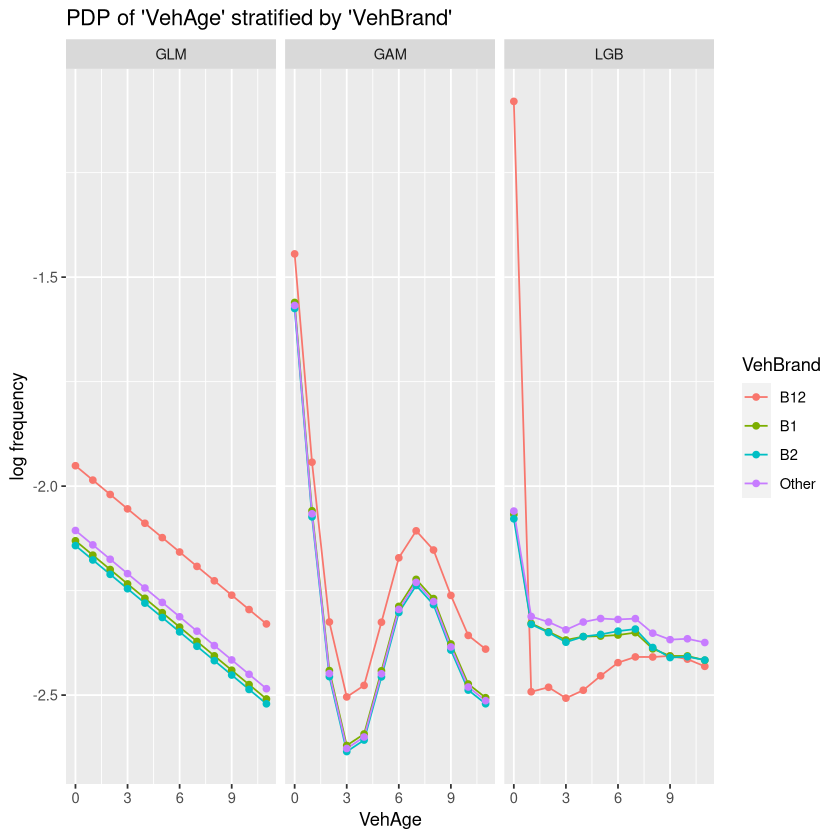

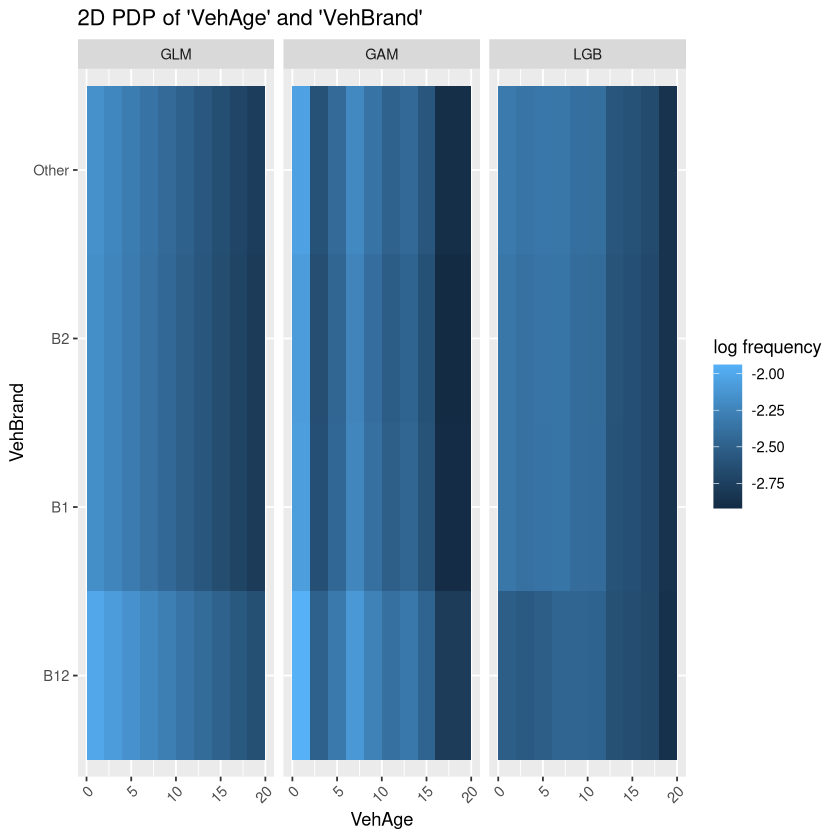

In [11]:
# Friedman's H-squared. Since the calculations take long, we cache the results
if (reload) {
  interact_rel <- readRDS(file.path(main, "interact_rel.rds"))
} else {
  interact_rel <- light_interaction(
    fls_log,
    v = most_important(imp, 4),
    pairwise = TRUE,
    take_sqrt = FALSE,
    use_linkinv = TRUE,
    seed = 61
  )
  saveRDS(interact_rel, file = file.path(main, "interact_rel.rds"))
}
plot(interact_rel, color = "black", fill = fillc) +
  labs(title = "Relative interaction strength", y = "Friedman's H-squared")

# H-tilde (absolute measure). Since the calculations take long, we cache the results
if (reload) {
  interact_abs <- readRDS(file.path(main, "interact_abs.rds"))
} else {
  interact_abs <- light_interaction(
    fls_log,
    v = most_important(imp, 4),
    pairwise = TRUE,
    normalize = FALSE,
    take_sqrt = TRUE,
    use_linkinv = TRUE,
    seed = 61
  )
  saveRDS(interact_abs, file = file.path(main, "interact_abs.rds"))
}
plot(interact_abs, color = "black", fill = fillc) +
  labs(title = "Absolute interaction strength", y = "H tilde")

# Visualization of strong interaction by studying a stratified PDP
light_profile(fls_log, v = "VehAge", by = "VehBrand", pd_evaluate_at = 0:11) |>
  plot() +
  labs(y = "log frequency", title = "PDP of 'VehAge' stratified by 'VehBrand'")

# Alternatively, we can also consider 2D PDP
light_profile2d(fls_log, v = c("VehAge", "VehBrand")) |>
  plot() +
  labs(fill = "log frequency", title = "2D PDP of 'VehAge' and 'VehBrand'")


**Comments:**

- From the first plot and the boosted trees model, it appears that about 30% of the combined effect of "VehAge" and "VehBrand" comes from their interaction. This interaction is also the strongest on an absolute scale. For the other pairs considered, the proportion of total effect explained by interactions is less than 10%. 
- By construction, the additive models do not show any interactions on the link scale. 
- The stratified PDP on the link scale clearly shows where the interaction occurs in the boosted trees model: the car age effect for brand "B12" is very different from the other brands. Note: if both variables were continuous, one of them would have to be binned to create such a plot.
- The two-dimensional partial dependence plot in the form of a heat map seems to be difficult to interpret. An interactive 3D plot could be a better solution.

# Global Surrogate Models

Another model-agnostic technique for examining the internals of a complex model $m$ goes back to @craven95, see @molnar2019 for a modern take. It works as follows: An intrinsically interpretable model $m_I$, usually a small decision tree, is fitted to the predictions of $\hat m$ using the same covariates as $m$ and minimizing the mean squared error. $\hat m_I$ is called a *(global) surrogate model* for $\hat m$. The higher the R-squared of $\hat m_I$, the better $\hat m$ can be explained by studying the surrogate $\hat m_I$.

## Remarks

- Since the calculation of $\hat m_I$ does not require the response $Y$, the global surrogate model can be calculated on the training or the test data.
- Variable importance measures calculated from $\hat m_I$ give a rough idea of the variable importance of the original model $\hat m$.

## Example

For our boosted trees model, a surrogate tree model looks like this:

[1] 0.8570248

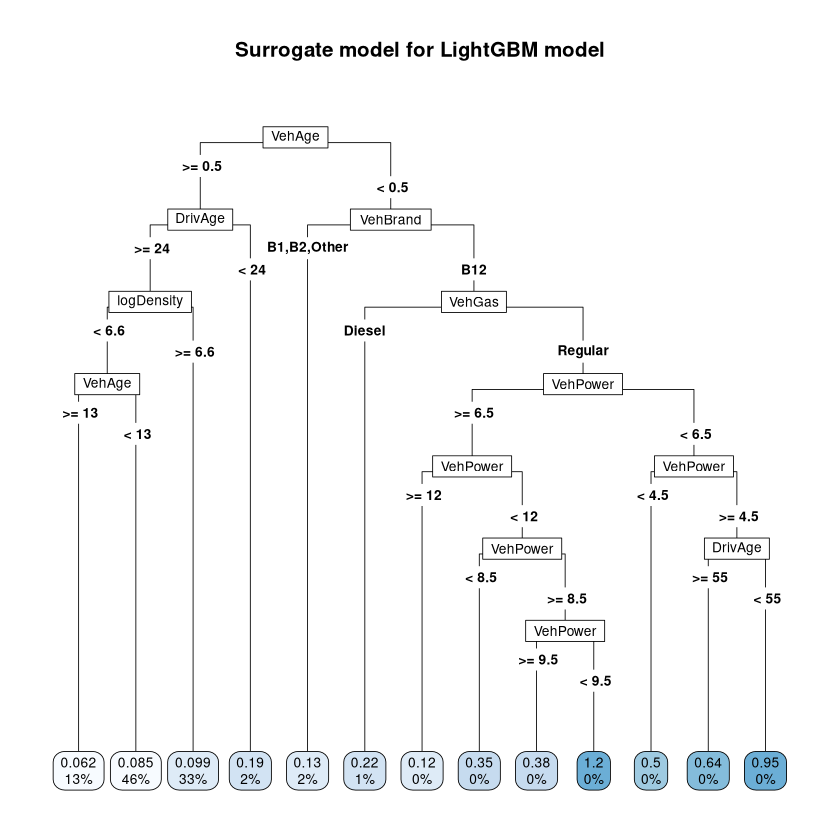

In [12]:
surr <- light_global_surrogate(fls$LGB, v = x)
surr$data$r_squared
plot(surr, main = "Surrogate model for LightGBM model")


**Comments:** 

- The surrogate model explains 86% of the variability in the predictions, providing a fairly accurate picture of the true internals of the complex boosted trees model.
- It can be easily explained to any audience. For example, we can say: "the worst frequencies are associated with new cars of brand 'B12' using regular fuel and with power between 8.5 and 9.5".

# Improve Linear Models by XAI

Sometimes there are good reasons (e.g. intrinsic explainability) for using a (generalized) linear model as the final model. However, building a strong linear model is quite complex: the modeler must consider *how* to represent the features and where to add nonlinear terms and interactions. A modern way to guide through these steps is to build a black box model and inspect it using XAI to obtain information about where and how to optimize the linear model.
Following @mayer2020, the basic logic is as follows:

1. *Performance:* How big is the performance difference between the optimized black box model and the initial linear model? If it is rather small, then the initial linear model may already be sufficiently good and does not need to be improved. On the other hand, if the performance difference is large, we can try to improve the linear model based on the next steps.
2. *Variable importance:* Did the black box model identify similar features as being important? If not, this could indicate a suboptimal feature representation in the linear model and/or missing interaction effects. This is where the next steps help.
3. *Main effects:* Do effects plots (e.g., partial dependence plots) of the important features look similar? If a feature shows highly non-linear effects in the black box model, then we should consider representing that feature in the linear model with the necessary flexibility, e.g., by using polynomials or regression splines.
4. *Interaction effects:* Often for simplicity, the initial linear model is built without interaction effects. Examining interaction strength of the black box model gives us an indication of which interaction effects could be added and how.

After going through these steps, the modified linear model can be re-examined. Hopefully, the results will now be closer to the optimized black box model while retaining intrinsic explainability.

## Example

Let us now try to optimize our GLM based on the insights gained so far: 

1. Performance: The GLM performs substantially worse than the other two models. Thus, there is still room for improvement.
2. Variable importance: According to permutation importance, the age of the car is the most important variable in all models. Apart from that, the rankings between the models are very different. Spending more flexibility to the GLM is indicated.
3. Main effects: The ICE plots and the partial dependence plots show large differences for some variables. Examples are the age of the driver and the age of the vehicle, for which linear effects do not seem realistic at all. For these covariates, we decide to use natural cubic splines in our GLM to represent their effects more realistically.
4. Interactions: In order to keep the resulting model intelligible, we only include the strongest interaction effect (vehicle brand and vehicle age) as identified by the boosted trees model.

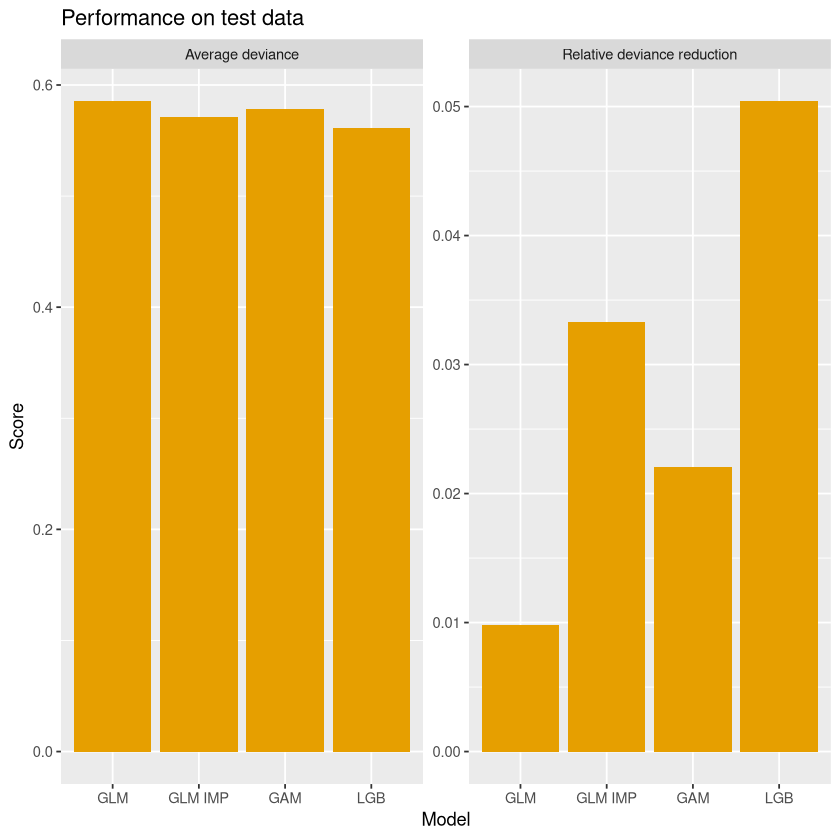

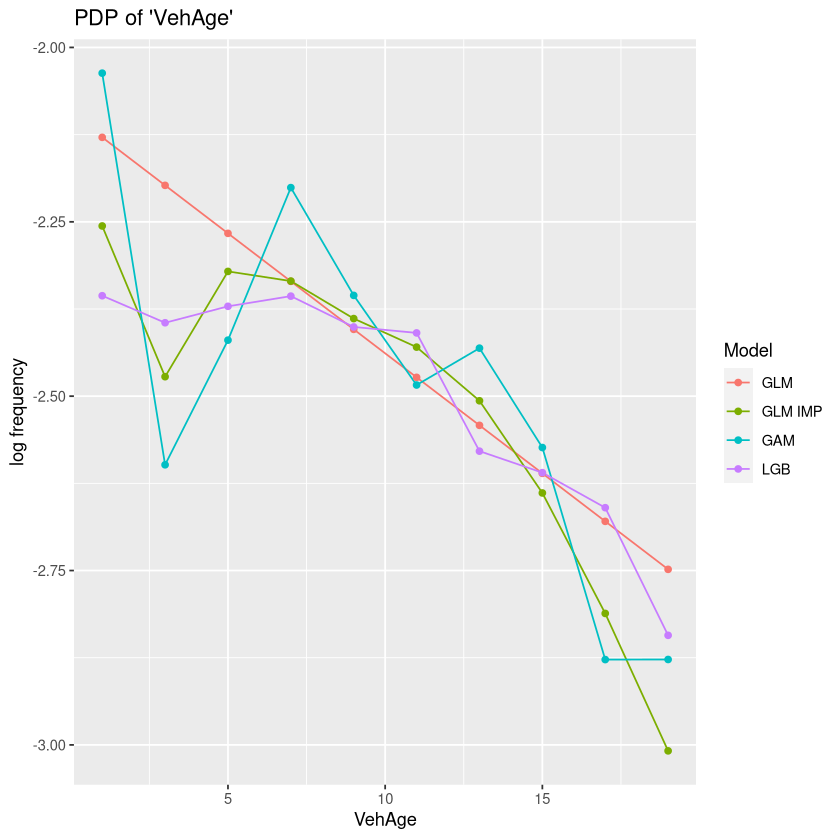

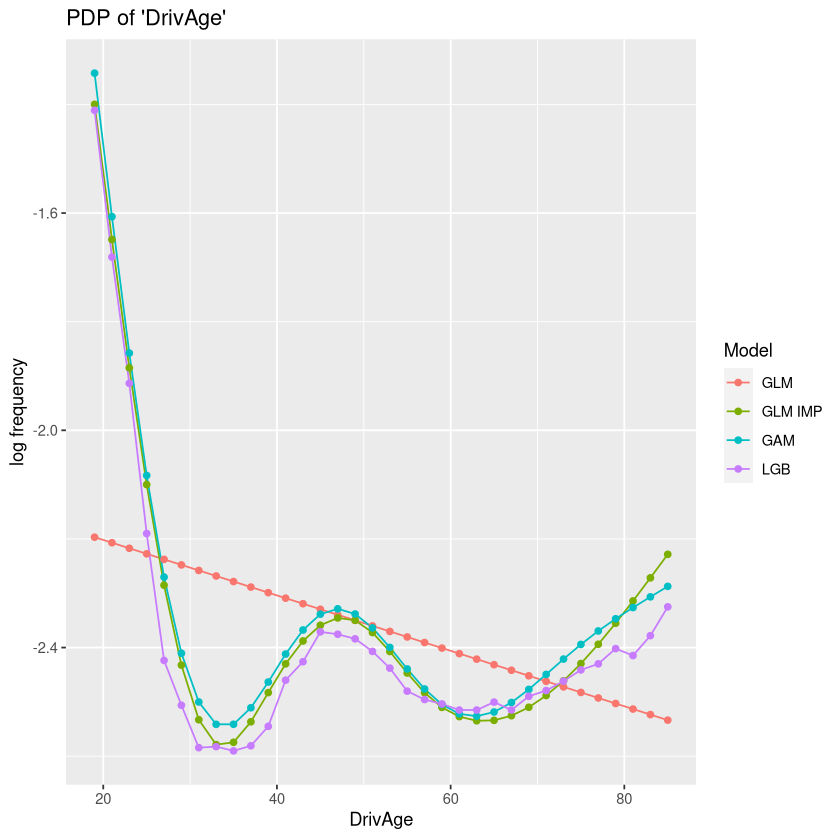

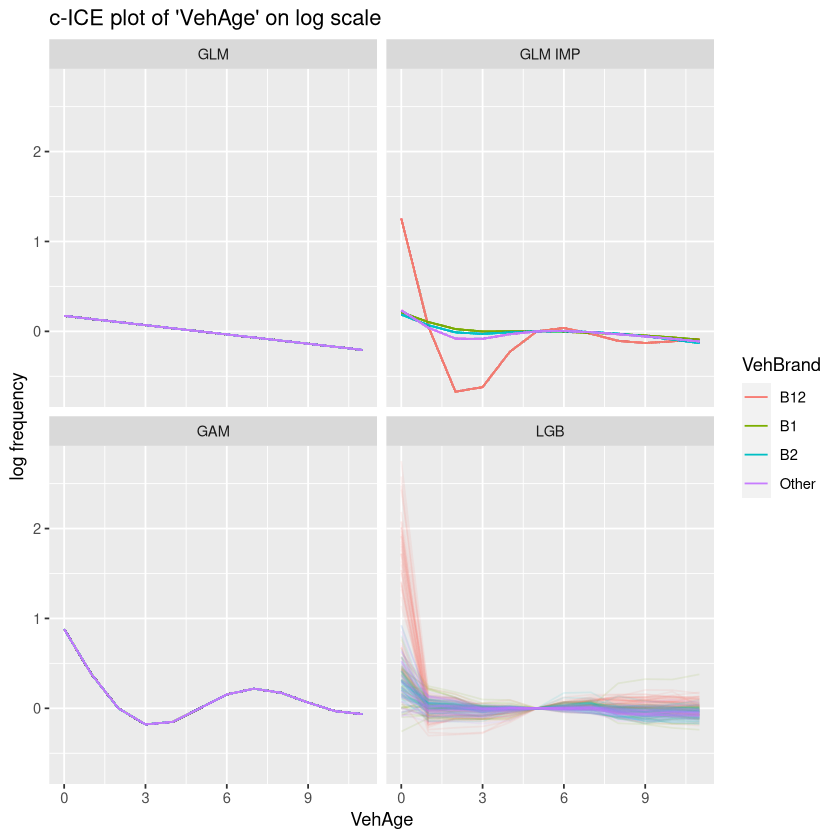

In [13]:
library(splines)

if (refit) {
  fit_glm_imp <- glm(
    Freq ~ VehPower + ns(VehAge, 5) * VehBrand + VehGas + ns(DrivAge, 5) + logDensity +
      PolicyRegion,
    data = train,
    family = quasipoisson(),
    weights = train[[w]]
  )
  saveRDS(fit_glm_imp, file = file.path(main, "fit_glm_imp.rds"))
} else {
  fit_glm_imp <- readRDS(file.path(main, "fit_glm_imp.rds"))
}

fl_glm_imp <- flashlight(
  model = fit_glm_imp, label = "GLM IMP", predict_function = pred_exp
)

fls_imp <- multiflashlight(
  list(fl_glm, fl_glm_imp, fl_gam, fl_lgb),
  data = test, y = y, w = w, metrics = metrics
)

# Version on link scale
fls_log_imp <- multiflashlight(fls_imp, linkinv = log)

# Performance
fls_imp |>
  light_performance() |>
  plot(fill = fillc) +
  labs(title = "Performance on test data", x = "Model", y = "Score")

# Effects: some partial dependence plots on link scale
light_profile(fls_log_imp, v = "VehAge", evaluate_at = c(0:11)) |>
  plot() +
  labs(title = "PDP of 'VehAge'", color = "Model", y = "log frequency")

light_profile(fls_log_imp, v = "DrivAge", n_bins = 25) |>
  plot() +
  labs(title = "PDP of 'DrivAge'", color = "Model", y = "log frequency")

# ICE plot conditional on brand
with_seed(
  3,
  indices <- sample(1:nrow(test), 200)
)

fls_log_imp |>
  light_ice(
    v = "VehAge",
    indices = indices,
    center = "middle",
    by = "VehBrand",
    evaluate_at = c(0:11)
  ) |>
  plot(alpha = 0.1) +
  labs(title = "c-ICE plot of 'VehAge' on log scale", y = "log frequency")


**Comments:**

- The model performance of the modified GLM has improved greatly, and thanks to interaction effects, it is now even better than the GAM. However, the boosted trees model is still much better. How could we further improve the performance of the modified GLM?
- The (main) effects for "DrivAge" and "VehAge" are now closer to those of the GAM and the boosted trees model. The stratified ICE plot of "VehAge" shows a very strong interaction effect of the improved GLM.
- The strategy of improving a linear model by inspecting a modern ML model by XAI seems to work well in this case.

# SHAP

SHAP (**SH**apley **A**dditive Ex**P**lanations) is the key player in explaining a ML model locally, i.e., around a single observation. It was introduced in @lundberg2017 and has since received much attention, not only when working with tabular data but also with unstructured data like text or images. The basic idea of SHAP is to decompose a model prediction into additive contributions of the features in a fair way. Repeating this process for many observations provides a powerful method for explaining the model as a whole. The roots of the method goes back to a classic result on cooperative game theory [@shapley1953]. Thus, and in contrast to many other local explainability methods, SHAP is based on a solid theoretic foundation.

Another important local technique is LIME (Local Interpretable Model-Agnostic Explanations, @ribeiro2016), primarily used for models with unstructured input like text or image data. It works as follows: An artificial dataset is created with feature values slightly different from those of the observation to be explained. Its predictions are then regressed on a simplified feature space by a white-box surrogate model, such as linear regression, assigning higher weights to more similar observations. This surrogate model provides a local interpretation of the original model in the neighborhood of the selected observation.

For more details on SHAP, see @mayer2023.

## Shapley values

So what is SHAP? To answer this question, we first introduce Shapley values from cooperative game theory.

Consider the following situation:

- Let $\mathcal M$ denote a set of $p = |\mathcal M|$ players.
- They play a cooperative game with numeric payoff to be maximized. 
- The contribution (total expected sum of payoffs) of a subset $\mathcal L \subseteq \mathcal M$ (or *coalition*) of the players is measured by a function $v: \mathcal L \mapsto \mathbb R$.

How can the total payoff be distributed fairly among the individual players? The answer was given in @shapley1953: The amount that player $j$ should receive is called *Shapley value* and equals
$$
  \phi_j(v) = \phi_j = \sum_{\mathcal L \subseteq \mathcal M \setminus\{j\}} \underbrace{\frac{|\mathcal L|!(p - |\mathcal L| - 1)!}{p!}}_\text{Shapley weight} \big(\underbrace{v(\mathcal L \cup \{j\}) - v(\mathcal L)}_{\text{Contribution of player } j}\big).
$$
Thus, a player's contribution is equal to the weighted average of his or her contribution to each possible coalition $\mathcal L$ of other players. 

This can be read as the (unweighted) average of the contribution of player $j$ over all $p!$ permutations of players. To see this, consider a permutation of the players. The $|\mathcal L|$ players appearing prior to player $j$ form the coalition $\mathcal L$, while the $p - |\mathcal L| - 1$ players $\mathcal Q$ *after* position $j$ do not play. We can permute the players in $\mathcal L$, and also the players in $\mathcal Q$ without effect on the contribution of player $j$. This leads to the numerator of the Shapley weight.

To characterize "fairness", Shapley postulated axioms that may be described by these four desirable properties:

- **Efficiency:** $v(\mathcal M) = \sum_{j = 0}^p \phi_j$, where $\phi_o = v(\emptyset)$ denotes the non-distributed payoff (often set to 0 in cooperative games).

- **Symmetry:** If $v(\mathcal L \cup \{i\}) = v(\mathcal L \cup \{j\})$ for every $\mathcal L \subseteq \mathcal M \setminus\{i, j\}$, then $\phi_i = \phi_j$.

- **Dummy player:** If $v(\mathcal L \cup \{j\}) = v(\mathcal L)$ for all coalitions $\mathcal L \subseteq \mathcal M \setminus\{j\}$, then $\phi_j = 0$.

- **Linearity:** Consider two cooperative games with gain functions $v$ and $w$. Then, $\phi_j(v + w) = \phi_j(v) + \phi_j(w)$ and $\phi_j(\alpha v) = \alpha \phi_j(v)$ for all $1 \le j \le p$ and $\alpha \in \mathbb R$.

Shapley values are the only way to distribute total winnings among players in a way that satisfies these four properties.

## Shapley values in statistics and ML

In statistics, Shapley values were proposed by @lipovetsky2001 as a strategy to decompose the R-squared of a linear regression into additive contributions of the covariates. Their approach was based on retraining the model for every feature subset. Other early work on Shapley values in statistics and ML include @strumbelj2010, @strumbelj2014, and @lundberg2017. They propose to use Shapley values to decompose *predictions* into feature contributions. Thus, the outcome of the cooperative game is the prediction, and the features are the players. 

Formally, the prediction $m(\boldsymbol x)$ of a given feature vector $\boldsymbol x$ is to be decomposed into contributions $\phi_j \in \mathbb R$, $1 \le j \le p$, such that
$$
  m(\boldsymbol x) = \phi_o + \sum_{j = 1}^p \phi_j,
$$
where typically $\phi_o = \mathbb E(m(\boldsymbol X))$. Only if the $\phi_j$ are Shapley values, the decomposition will be fair. In order to apply Shapley's formula, a contribution function $v$ must be selected. A natural candidate is
$$
  v(\mathcal L) = m(\mathbf x_\mathcal L),
$$
where $\mathbf x_\mathcal L$ represents the components in the feature subset $\mathcal L \subseteq \mathcal M$ selected from the full feature set $\mathcal M$. 
Since models cannot simply "turn off" some features during prediction, the estimation of $m(\mathbf x_\mathcal L)$ is highly non-trivial, and there is some controversy (see e.g., @sundararajan2019 or @janzing2020) whether to approximate it using marginal expectations $\mathbb E_{\mathbf X_{\mathcal M \setminus \mathcal L}}(m(\boldsymbol X))$ or conditional expectations $\mathbb E(m(\boldsymbol X \mid \mathbf x_\mathcal L))$. The core question is: should the statistical dependence between features in $\mathcal L$ and features in $\mathcal M \setminus \mathcal L$ be broken (marginal) or not (conditional)? The rules of causal inference require the former, while statistically, the latter would be more natural.

There exist several algorithms to calculate SHAP values for an observation $\mathbf x$. Three particularly important ones are the following (from very slow to very fast):

- **Monte-Carlo sampling** [@strumbelj2010]: To calculate $\phi_j$ for a particular $j$, the contributions $m(\mathbf x_{\mathcal L \cup \{j\}}) - m(\mathbf x_\mathcal L)$ are calculated as marginal expectations for many randomly sampled feature subset $\mathcal L \subseteq \mathcal M \setminus \{j\}$ and then plugged into Shapley's formula. Marginal expectations are calculated empirically with respect to some background data set. This method is model-agnostic, but either very slow or very imprecise.
- **Kernel SHAP** [@lundberg2017]: Another model-agnostic algorithms is called Kernel SHAP. Like Monte-Carlo sampling, it estimates $m(\mathbf x_\mathcal L)$ via marginal expectations for many $\mathcal L \subseteq \mathcal M$. Then, it uses a regression trick to obtain all $\phi_j$ directly without plugging into Shapley's formula, see @covert2021 for details. @aas2021 proposed a version using conditional expectations instead.
- **TreeSHAP** [@lundberg2020] is a method tailored for decision trees. It estimates $m(\mathbf x_\mathcal L)$ by a conditional expectation using a recursive (path-dependent) algorithm identical to a method for calculating exact partial dependence plots for decision trees in @friedman2001, page 27. To evaluate Shapley's formula, the basic algorithm must be applied to each $\mathcal L \subseteq \mathcal M$ and is therefore exponentially slow in $p$. Fortunately, the algorithm has been implemented in a way that evaluates all subsets $\mathcal L$ together, resulting in an exponential speedup. Also a slower "interventional" version exists that estimates marginal expectations. Thanks to additivity of SHAP values, TreeSHAP works well for tree ensembles such as boosted trees.

We won't go into more detail about *how* the above methods work but rather note:

>SHAP has a solid theoretical foundation. In practice, some of it is lost because statistics is not mathematics.

Remark: In the following two situations, exact Shapley values can be calculated:

- $p = 1$, i.e., there is only a single feature $Z$. Here, the contribution of $Z$ is simply $\phi_1 = m(z) - \phi_o$.
- $m$ is a linear regression with *uncorrelated* features:
$$
  m(\boldsymbol x) = \underbrace{\beta_0}_{\phi_o} + \underbrace{\beta_1 x^{(1)}}_{\phi_1} + \dots + \underbrace{\beta_p x^{(p)}}_{\phi_p}
$$
(using mean-centered features for notational simplicity), see @aas2021 for a proof.

Before we dive into an example, here are the main reasons for SHAP's success:

1. Its solid theoretical basis.
2. A fast implementation (TreeSHAP).
3. Scott Lundberg's Python package "shap".

### Example

Throughout this section, we will use the claims frequency model fitted with boosted trees. SHAP values are calculated with the TreeSHAP algorithm included in LightGBM. It provides SHAP values on the link scale.

What is the SHAP decomposition for the first observation?

'shapviz' object representing 
  - SHAP matrix of dimension 1 x 7 
  - feature data.frame of dimension 1 x 7 
  - baseline value of -2.370107

SHAP values of first 1 observations:
       VehPower    VehAge  VehBrand    VehGas   DrivAge  logDensity
[1,] -0.1043855 0.8894755 0.1658873 0.3411239 0.6090654 -0.03021891
     PolicyRegion
[1,]  -0.03361134

 Corresponding feature values:
  VehPower VehAge VehBrand  VehGas DrivAge logDensity PolicyRegion
1        4      0      B12 Regular      18   3.871201        Other



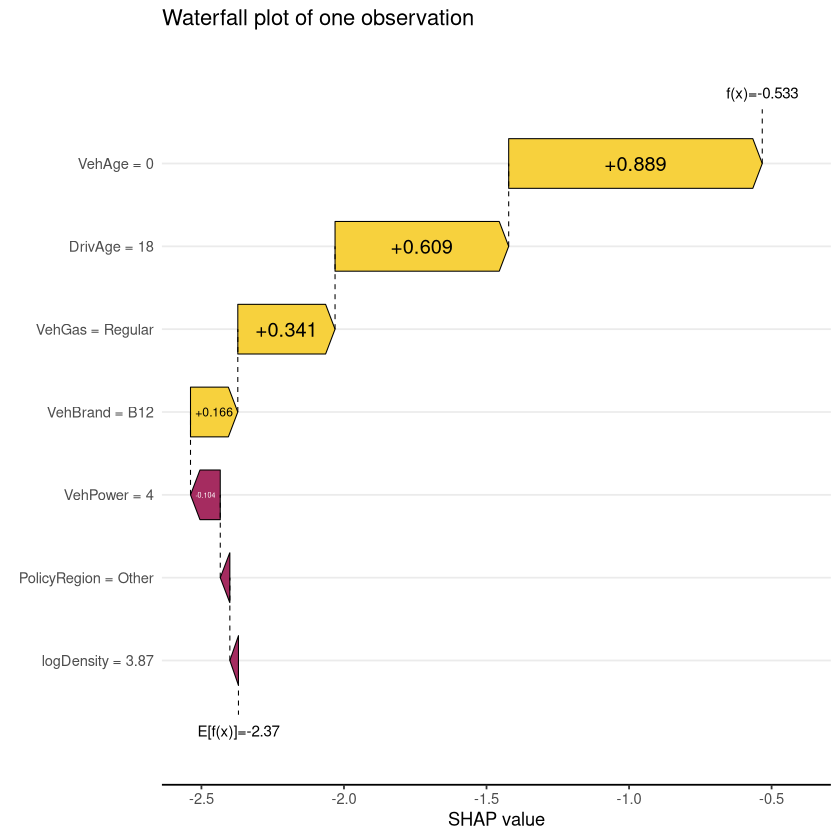

[1] -0.532771

[1] -0.532771

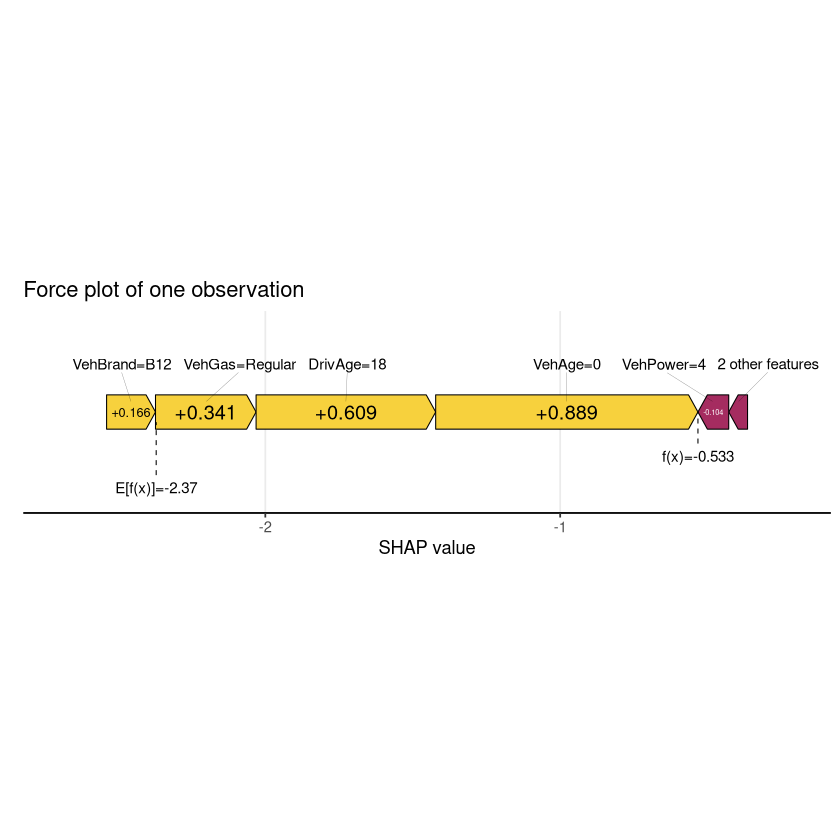

In [14]:
library(shapviz)

# Calculate SHAP decomposition for first observation
train_1 <- train[1, x]
shp <- shapviz(fit_lgb, X_pred = data.matrix(train_1[x]), X = train_1)
summary(shp)

# Two typical visualizations
sv_waterfall(shp) +
  ggtitle("Waterfall plot of one observation")

# For slides
# sv_waterfall(shp, annotation_size = 5, size = 18) +
#   theme(axis.text = element_text(size = 15), axis.title = element_text(size = 18))

sv_force(shp) +
  ggtitle("Force plot of one observation")

# Does sum of SHAP equals prediction at log link?
get_baseline(shp) + sum(get_shap_values(shp))
predict(fit_lgb, data.matrix(train_1[x]), rawscore = TRUE)


**Comments:**

- Both plots explain how the difference between the baseline ($\phi_0=-2.37$) and the prediction $-0.533$ can be attributed to the features. The strongest effect comes from the fact that the car is new. An age of 18 years and the use of regular gas explain almost all the rest. (Note that "f(x)" is our $\hat m(\boldsymbol x)$ and "E[f(x)]" is our $\phi_o$.)
- Reading example: The car of the first observation is new. The corresponding SHAP value of "VehAge" is 0.889, which represents a large increase in the log expected frequency compared to the average prediction $\phi_0=-2.37$. 
- Adding the sum of all SHAP values to the baseline results in the prediction on the scale of the link.

## From local to global explanations

Interpreting the model locally around a particular observation, while interesting, provides little information about the model as a whole, i.e., at the global level. However, we can compute SHAP decompositions for a sufficiently large set of $n$ observations and then use descriptive statistics to derive global properties of the model. Thanks to the very fast TreeSHAP algorithm, this works especially well for tree-based models.

Let $X$ be the $(n \times p)$ feature matrix with elements $x_{ij}$ and $\Phi$ the corresponding $(n \times p)$ matrix of SHAP values with elements $\phi_{ij}$, $1 \le i \le n$, $1 \le j \le p$. Furthermore, let $\phi_o = \frac{1}{n} \sum_{i = 1}^n \hat m(\boldsymbol x_i)$ be the average prediction over the $n$ observations with feature vectors $\boldsymbol x_i$. By construction, the SHAP values satisfy
$$
  \hat m(\boldsymbol x_i) = \phi_o + \sum_{j = 1}^p \phi_{ij}
$$
for all $1 \le i \le n$. Based on $X$ and $\Phi$, we can investigate feature importance and feature effects using descriptive statistics. 

### Importance

The absolute SHAP value $|\phi_{ij}|$ quantifies the importance of feature $j$ in predicting observation $i$. Taking the average over the $n$ observations results in a variable importance measure called *SHAP feature importance*, defined as
$$
  I_j=\frac{1}{n}\sum_{i=1}^n|\phi_{ij}|.
$$
The interpretation is simple: $I_j$ indicates the average absolute impact of feature $j$ on the prediction.

The values of $I_j$ can be visualized as a bar plot. An alternative is the so-called *SHAP summary plot*. It shows for each feature $j$ a horizontal scatter plot of the SHAP values $\phi_{ij}$, where the vertical scatter is proportional to their density. Such a *beeswarm plot* is usually enhanced by highlighting the (min-max scaled) feature values on the color axis. In this way, the direction of the effect can be seen, i.e., whether high feature values would increase or decrease predictions.

#### Example

Let us now decompose the predictions of $n = 2000$ randomly picked observations from the training data and examine their SHAP importance.

   user  system elapsed 
 11.577   0.003   1.847 

'shapviz' object representing 
  - SHAP matrix of dimension 2000 x 7 
  - feature data.frame of dimension 2000 x 7 
  - baseline value of -2.370107

SHAP values of first 2 observations:
        VehPower     VehAge    VehBrand       VehGas      DrivAge    logDensity
[1,] -0.06988427 -0.1658914 -0.01690778 -0.011529385 -0.005529087  0.1457284284
[2,]  0.11507993 -0.0101461 -0.03222512  0.009950284 -0.094215458 -0.0007195013
     PolicyRegion
[1,]  -0.08969426
[2,]  -0.05073782

 Corresponding feature values:
  VehPower VehAge VehBrand  VehGas DrivAge logDensity PolicyRegion
1        4     13       B1 Regular      53   7.721792        Other
2       11      2      B12  Diesel      55   6.198479        Other



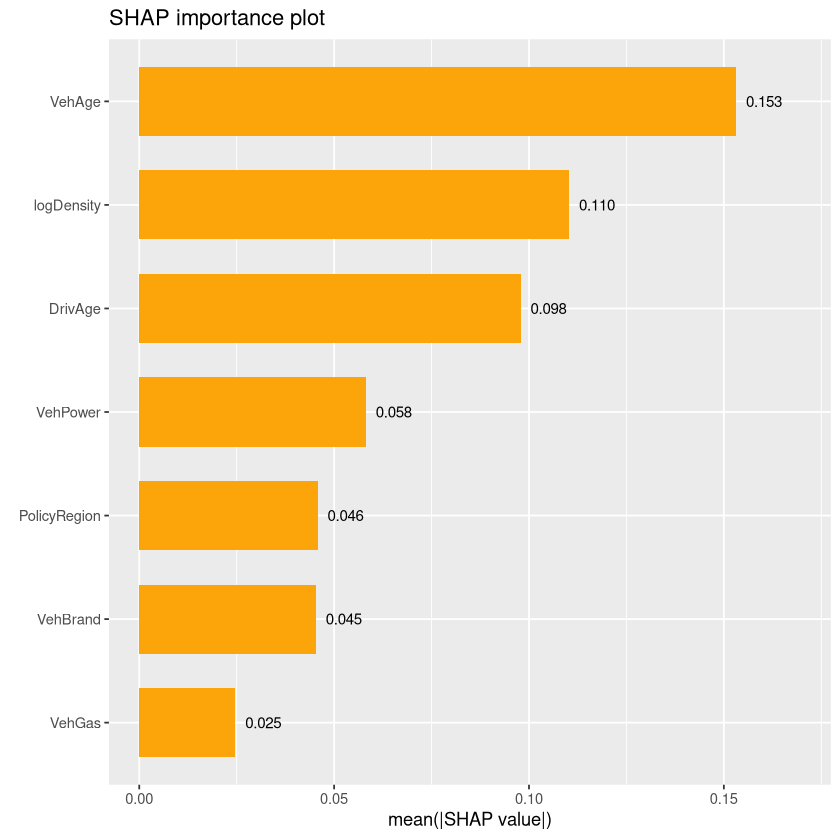

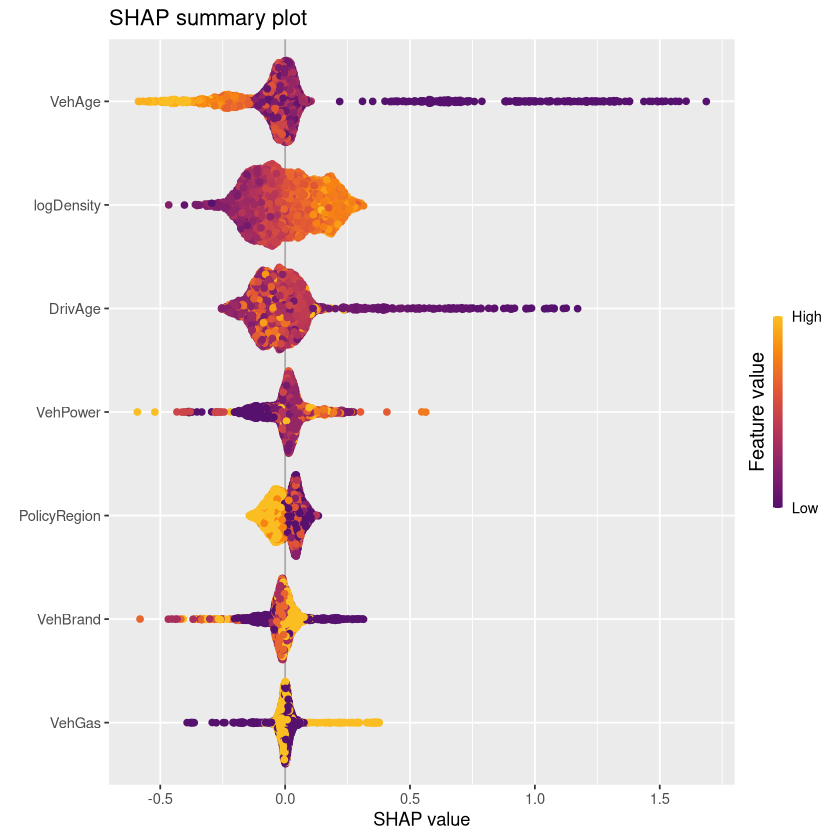

In [15]:
with_seed(
  536,
  train_small <- sample_n(train[x], 2000)
)

system.time(
  shp <- shapviz(fit_lgb, X_pred = data.matrix(train_small[x]), X = train_small)
)
summary(shp)

sv_importance(shp, show_numbers = TRUE) +
  ggtitle("SHAP importance plot")

sv_importance(shp, kind = "beeswarm") +
  ggtitle("SHAP summary plot")


**Comments:**

- As with permutation importance, vehicle age is considered the most important variable. Otherwise, the ranking is quite different. The interpretation of SHAP importance is straightforward: on average, the vehicle age shifts the prediction up or down the log-frequency scale by about 0.15. With plus or minus 0.025, the average impact from "VehGas" is much smaller.
- The beeswarm plot also shows the *direction* of the effect: We can see that a low vehicle age is associated with a strong positive effect. The features in such a beeswarm plot are usually ordered by their SHAP importance.
- TreeSHAP is blazingly fast.

### Effects

To see *how* a feature affects the prediction, *SHAP dependence plots* are useful. The dependence plot of a feature $j$ plots the SHAP values $\phi_{ij}$ against the corresponding feature values $x_{ij}$. Thus, it represents the graph
$$
  \{(x_{ij}, \phi_{ij}), 1 \le i \le n\}.
$$

#### Example

How does the dependence plot of feature "VehAge" looks like?

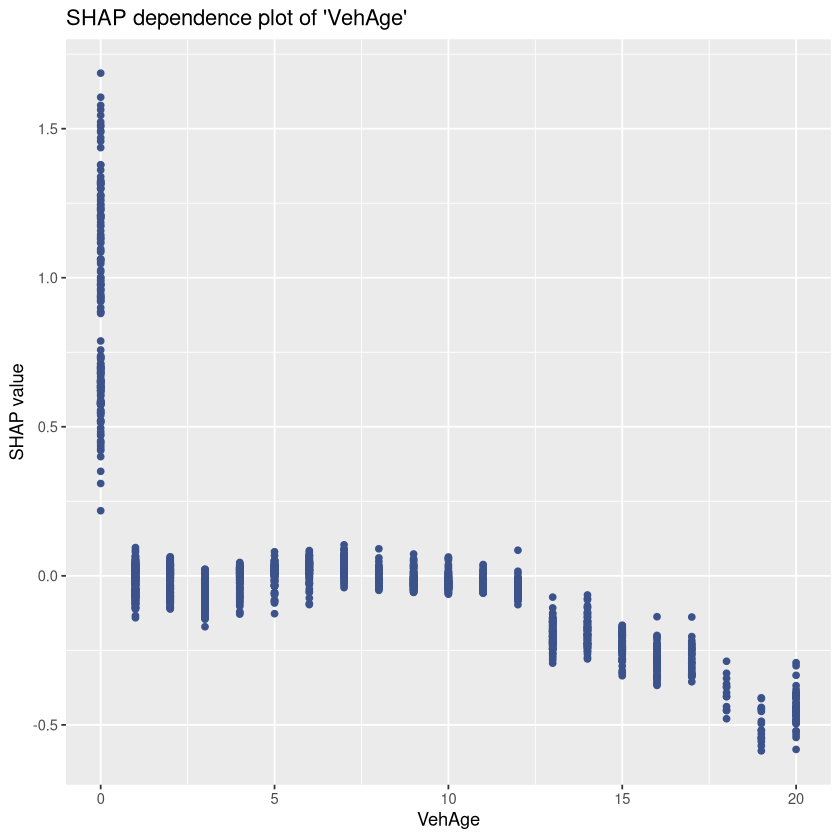

In [16]:
sv_dependence(shp, "VehAge", color_var = NULL) +
  ggtitle("SHAP dependence plot of 'VehAge'")


**Comments:**

- The SHAP values of observations with a vehicle age of 0 are very high. This means that new vehicles strongly increase the expected claims frequency. The effect for ages between one and twelve years is quite close to 0. For older vehicles, a clear negative trend can be seen.
- For a given vehicle age, SHAP values differ from observation to observation. This vertical scatter means that there are interaction effects with other features of the model (why?).

### Interactions

At least two approaches are common to study interaction effects using SHAP:

1. SHAP interactions: SHAP decomposes a prediction into additive contributions of each feature. In the same vein, @lundberg2020 introduced *SHAP interactions*, which decompose a prediction into additive contributions of each feature *pair*. Compared to ordinary SHAP, the computational complexity increases by a factor $p$, which is why SHAP interaction values are mainly used with the very fast TreeSHAP algorithm, i.e., for tree-based models.

2. Heuristics: Several heuristics are available that try to identify the feature that explains most of the vertical scatter in the dependence plot conditional on the value on the horizontal axis. The selected feature is then visualized on the color axis.

#### Example

Using Approach 2, we now highlight a strongly interacting feature on the color axis.

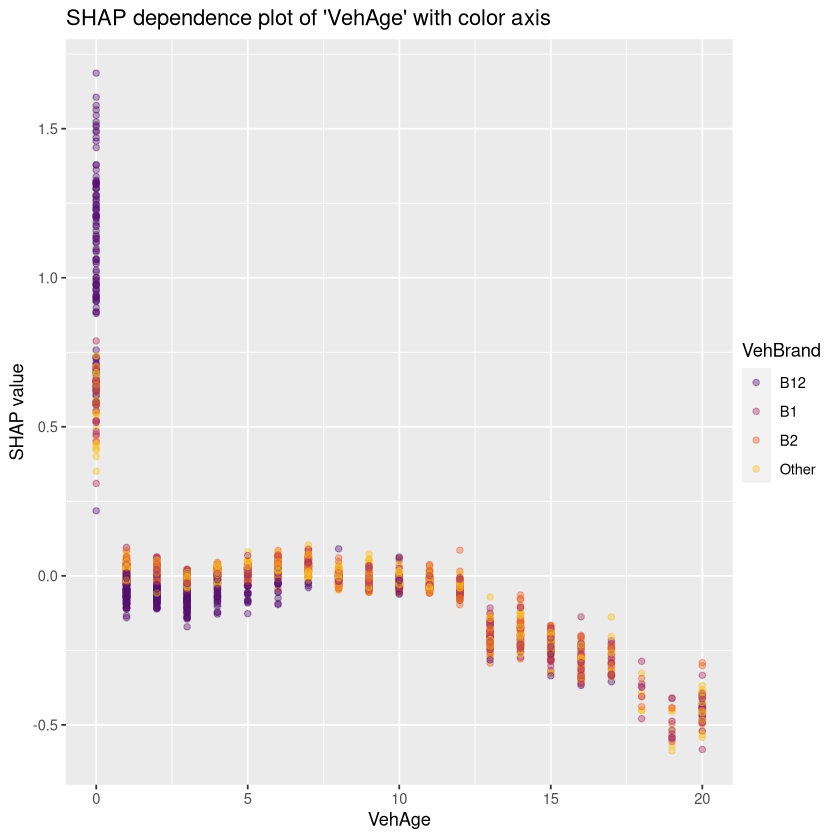

In [17]:
sv_dependence(shp, "VehAge", alpha = 0.4) +
  ggtitle("SHAP dependence plot of 'VehAge' with color axis")


**Comments:**

- Vehicle brand was selected as the feature with the heuristically strongest interaction with "VehAge".
- The plot shows *how* the interaction manifests itself: "B12" vehicles increase the expected claim frequency for brand-new cars, while otherwise decreasing it. This is consistent with what we found by examining the conditional partial dependence plot in the section on interactions.

### Remarks

- SHAP decompositions explain the fitted model, not the actual underlying relationships. Therefore, a SHAP analysis is as good or as bad as the model. This also means that we can select observations from either the training or the test data.
- For models involving link functions, predictions are usually decomposed on the scale of the link.
- Thanks to additivity, the SHAP values of a claims frequency model and its corresponding severity model can be combined on the logarithmic scale. This provides explanations for the resulting pure premium model.

### Example: Full SHAP analysis

A typical workflow with tree-based models is to decompose many ($1000-2000$ predictions), study SHAP importance and the dependence plots of all features. What are we waiting for?

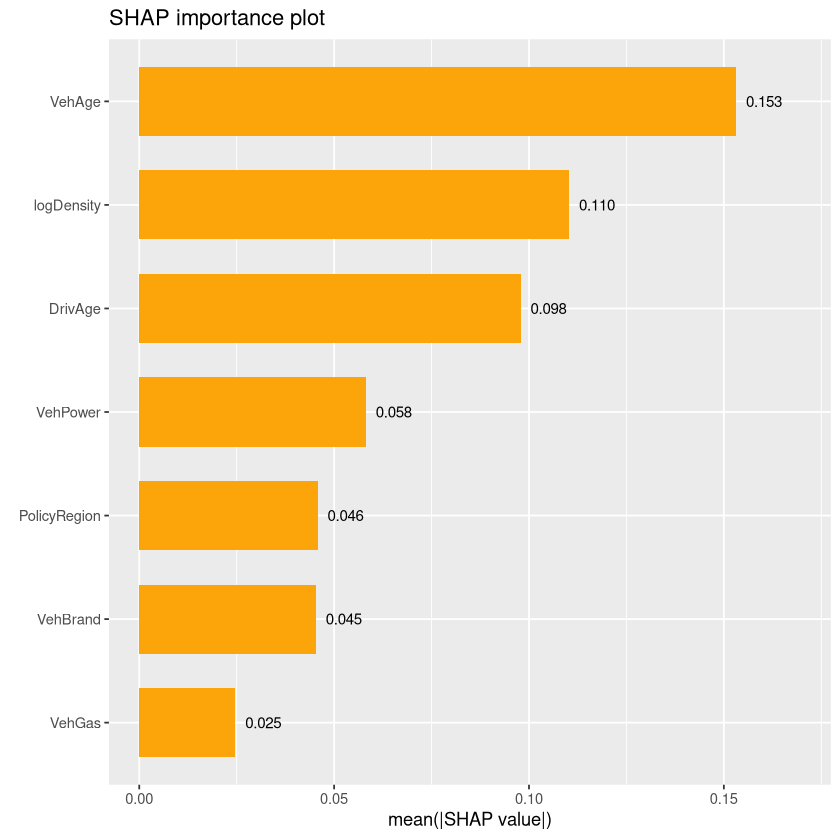

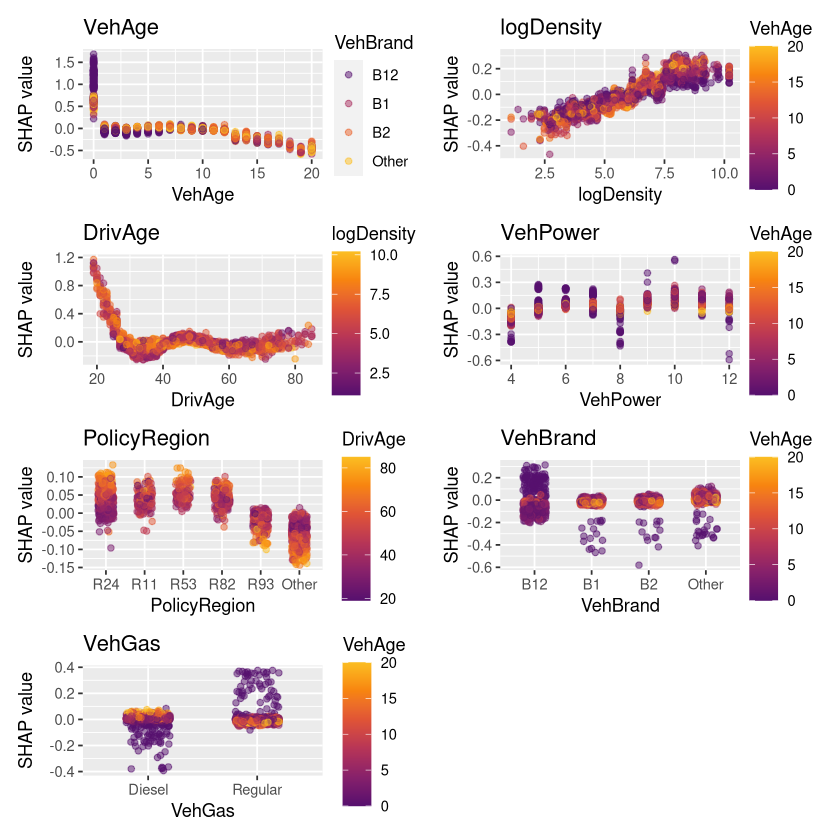

In [18]:
# Crunch SHAP decompositions for 2000 observations
with_seed(
  536,
  train_small <- sample_n(train[x], 2000)
)
shp <- shapviz(fit_lgb, X_pred = data.matrix(train_small[x]), X = train_small)

# SHAP importance plot
sv_importance(shp, show_numbers = TRUE) +
  ggtitle("SHAP importance plot")

# Dependence plots in decreasing order of importance
sv_dependence(shp, v = names(sv_importance(shp, kind = "no")), alpha = 0.5) +
  plot_layout(ncol = 2)


**Comments:**

- Importance: See the example above.
- The SHAP dependence plots show quite realistic effects. For most features they give a similar impression as the corresponding partial dependence plots.
- The SHAP dependence plots also give indications of interaction effects. For example, there is a very strong interaction between vehicle age and car brand in the sense that "B12" vehicles tend to have higher claim frequencies only for new vehicles.
- The vertical scatter is quite strong for all dependence plots, indicating strong interactions. For example, the effect of vehicle gas appears to depend strongly on vehicle age. Another example is the policy region: its effects are particularly strong for older drivers.

### SHAP analysis to improve linear model

It is amazing how much information can be generated with so few lines of code. If the ultimate goal of the modeling task is to obtain a strong (generalized) linear model, we can develop an ML model, evaluate its performance, perform a compact SHAP analysis, and then use these findings to craft a strong GLM. This adopts the logic from the section "Improving Linear Models through XAI" in an extremely efficient manner.

#### Example

From the plots above, we could say:

*Importance:* "VehAge", "logDensity" and "DrivAge" are the three most important features. The GLM will hopefully benefit if their effects are well represented. There is no variable that we should omit.

*Effects:*

- Vehicle age could be represented by a smooth curve plus a dummy variable distinguishing new cars from the rest.
- Driver age could be represented by a smooth curve.
- An interaction between brand B12 and new cars could be added.
- An interaction between gas and newer cars could be added.

Let us modify the GLM accordingly and focus on the resulting test performance:

In [19]:
library(splines)
library(MetricsWeighted)

if (refit) {
  fit_glm_imp2 <- glm(
    Freq ~ (VehAge == 0) + ns(VehAge, 4) + I(VehAge == 0):I(VehBrand == "B12") +
      VehBrand + logDensity + ns(DrivAge, 5) + VehPower + VehGas + VehGas:I(VehAge <= 5),
    data = train,
    family = quasipoisson(),
    weights = train[[w]]
  )
  saveRDS(fit_glm_imp2, file = file.path(main, "fit_glm_imp2.rds"))
} else {
  fit_glm_imp2 <- readRDS(file.path(main, "fit_glm_imp2.rds"))
}

# Calculate relative Poisson deviance gain
fit0 <- glm(Freq ~ 1, data = train, family = quasipoisson(), weights = train[[w]])
pred <- predict(fit_glm_imp2, test, type = "response")
pred0 <- predict(fit0, test, type = "response")
dev <- deviance_poisson(test[[y]], pred, test[[w]])
dev0 <- deviance_poisson(test[[y]], pred0, test[[w]])
(dev0 - dev) / dev0


[1] 0.03582301

**Comment:** The relative deviance gain is clearly higher compared to the original GLM (1%) and also better than the first improved version `fit_glm_imp` (3.3%).

# Exercises

1. As in the exercises for the first chapter, we will work with the `dataCar` data. To make the example self-contained, we repeat data preprocessing and modeling.

In [ ]:
library(withr)
library(tidyverse)
library(insuranceData)
library(ranger)
library(xgboost)
library(MetricsWeighted)
library(flashlight)
library(shapviz)
library(patchwork)

data(dataCar)

# Data preparation
prep <- dataCar |>
  mutate(
    Freq = numclaims / exposure,
    Sev = claimcst0 / numclaims,
    veh_age = factor(veh_age),
    agecat = factor(agecat),
    veh_body = fct_lump_prop(veh_body, 0.1),
    log_value = log(pmax(0.3, pmin(15, veh_value)))
  )

# Modeling
y_var <- "Freq"
w_var <- "exposure"
x_vars <- c("log_value", "agecat", "veh_age", "area", "veh_body", "gender")

with_seed(
  304,
  ix <- sample(nrow(prep), 0.8 * nrow(prep))
)
train <- prep[ix, ]
test <- prep[-ix, ]

form <- reformulate(x_vars, y_var)
fit_glm <- glm(form, data = train, weights = train[[w_var]], family = quasipoisson())
fit_rf <- ranger(
  form,
  data = train, case.weights = train[[w_var]], max.depth = 4, seed = 400
)

# XGBoost
dtrain <- xgb.DMatrix(
  data.matrix(train[, x_vars]),
  label = train[[y_var]], weight = train[[w_var]]
)

# Hyperparameters
params <- list(
  learning_rate = 0.05,
  objective = "count:poisson",
  max_depth = 2,
  colsample_bynode = 0.8,
  subsample = 0.8,
  reg_alpha = 1,
  reg_lambda = 0,
  min_split_loss = 0.001
)

with_seed(
  345,
  fit_xgb <- xgb.train(params = params, data = dtrain, nrounds = 196)
)


1. Performance
    i. Calculate weighted average Poisson deviances of the three models both on the training data as well as on the test data. What do you observe? Hint: You may use the {MetricsWeighted} package.
    ii. By how much percentage points are the test deviances better than an intercept-only model?
2. Variable importance
    i. How is permutation importance of a feature $X^{(j)}$ being calculated with respect to weighted Poisson deviance on the test data?
    ii. Identify the two most important features per model according to this measure.
    iii. What are the advantages/disadvantages when repeating the permutation importance calculation multiple times?
3. Effects
    i. Study centered ICE plots of feature "agecat" on the frequency scale. Why do the plots show interaction effects for all models?
    ii. Study partial dependence plots of all features and models on the frequency scale.
    iii. Show that the coefficient $\hat \beta_j$ of covariate $X^{(j)}$ in a linear regression model 
    $$
    \hat m(\boldsymbol x) = \hat \beta_o + \hat \beta_1 x^{(1)} + \dots + \hat \beta_p x^{(p)}
    $$
    equals the slope of the partial dependence line of $X^{(j)}$.
    iv. Optional. Write an R function `partial_dependence(data, v, model, pred_fun, ...)` that creates a partial dependence plot for variable `v`. `data` is the reference data, `v` the column name of the variable to trace, `model` the fitted model, and finally `pred_fun` the prediction function taking the model and a data set like `data` as arguments.
    v. Optional. Modify your function to allow an additional argument `w`, specifying a vector of case weights used to create a weighted partial dependence plot. Do you get similar results than in ii?
    vi. According to squared Friedman's H: Between which two variable pairs does the XGBoost model detect the strongest interactions?
4.  Improve GLM
    Use the insights of above exercises to improve the GLM. Explain your changes and evaluate the modified GLM. For simplicity, do not add interaction effects.
5.  SHAP (use only the XGBoost model here)
    i. Search two observations with similar predictions, but relatively different feature values. Compare their waterfall plots.
    ii. Perform a SHAP analysis and summarize your findings in a compact way.
    iii. Can you improve the original GLM based on these insights?

# References